In [1]:
library(lme4)
library(MCMCglmm)
library(broom)
library(nadiv)
library(tidyverse) #%>%

Warning message:
"package 'lme4' was built under R version 3.6.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 3.6.3"
Warning message:
"package 'MCMCglmm' was built under R version 3.6.3"
Loading required package: coda

Warning message:
"package 'coda' was built under R version 3.6.3"
Loading required package: ape

Warning message:
"package 'ape' was built under R version 3.6.3"
Warning message:
"package 'nadiv' was built under R version 3.6.3"

Attaching package: 'nadiv'


The following object is masked from 'package:MCMCglmm':

    prunePed


Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'tibble' was built under R version 

In [2]:
library(parallel)
my.cores = detectCores()

In [3]:
#FROM INTERNET!!!
clean.MCMC <- function(x) {
    sols <- summary(x)$solutions  ## pull out relevant info from model summary
    Gcovs <- summary(x)$Gcovariances
    Rcovs <- summary(x)$Rcovariances
    fixed <- data.frame(row.names(sols), sols, row.names = NULL)  ## convert to dataframes with the row.names as the first col
    random <- data.frame(row.names(Gcovs), Gcovs, row.names = NULL)
    residual <- data.frame(row.names(Rcovs), Rcovs, row.names = NULL)
    names(fixed)[names(fixed) == "row.names.sols."] <- "variable"  ## change the columns names to variable, so they all match
    names(random)[names(random) == "row.names.Gcovs."] <- "variable"
    names(residual)[names(residual) == "row.names.Rcovs."] <- "variable"
    fixed$effect <- "fixed"  ## add ID column for type of effect (fixed, random, residual)
    random$effect <- "random"
    residual$effect <- "residual"
    modelTerms <- as.data.frame(bind_rows(fixed, random, residual))  # merge it all together
}
getName.MCMC <- function(x) deparse(substitute(x))  # add the model name

# Download data

In [4]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
path_model = file.path(path_adapt,'repeatability_model')
df = read.csv(file.path(path_adapt,'df_MVT_4stat_BI.csv'), header = TRUE, sep = ";")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
#mean-centering of the environmental variable so that intercepts reflect average values for the population and individuals
df$cDIB = as.integer(df$DIB) 
df$cDIB2 = poly(df$cDIB, degree=2,raw=TRUE)[,2]
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment) 
#scale all continuous fixed effectcs
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$cDIB2_scale = scale(df$cDIB2, center=TRUE, scale=TRUE)
df$cDIB_scale = scale(df$cDIB, center=TRUE, scale=TRUE)
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
df$PC3scale = scale(df$PC3, center=TRUE, scale=TRUE)
df$InitialWeight_kg_scale = scale(df$InitialWeight_kg, center=TRUE, scale=TRUE)
df = df %>%mutate(rel_severity = severity/mean(severity, na.rm=TRUE))
df$FeatherDamage = 100-df$Feathers
df = df %>%mutate(rel_feather = Feathers/mean(Feathers, na.rm=TRUE))
print(dim(df))
summary(df)
head(df,3)

[1] 3230   55


   Unnamed..0          WIB            HenID           RPen      
 Min.   :   1.0   Min.   :2.000   hen_116:  43   Min.   :1.000  
 1st Qu.: 808.2   1st Qu.:4.000   hen_124:  43   1st Qu.:1.000  
 Median :1615.5   Median :5.000   hen_127:  43   Median :2.000  
 Mean   :1615.5   Mean   :5.222   hen_136:  43   Mean   :2.448  
 3rd Qu.:2422.8   3rd Qu.:7.000   hen_147:  43   3rd Qu.:3.000  
 Max.   :3230.0   Max.   :8.000   hen_151:  43   Max.   :4.000  
                                  (Other):2972                  
      DIB          CLASS                  TrackingSystemID     PenID    
 Min.   :11.00   LEXP : 965   TrackingSystem 10-12:1302    pen10  :504  
 1st Qu.:23.00   MEXP :1379   TrackingSystem 3-5  :1069    pen11  :504  
 Median :33.00   Other: 886   TrackingSystem 8-9  : 859    pen8   :430  
 Mean   :33.59                                             pen9   :429  
 3rd Qu.:44.00                                             pen4   :388  
 Max.   :54.00                            

,Unnamed..0,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,...,ri_fit,rr_fit,nbr_nbrzonevisisted_over_3days,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd,PC3scale,InitialWeight_kg_scale,FeatherDamage,rel_feather
,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,1,2,hen_134,4,11,MEXP,TrackingSystem 10-12,pen10,11.50000,TRAN,...,0.1555927,-0.7028166,9,1,-0.8704775,0.09785196,-0.4555078,-0.9142959,27,1.109245
2,2,2,hen_134,4,12,MEXP,TrackingSystem 10-12,pen10,10.16667,TRAN,...,0.1822498,-0.6188933,9,1,-0.8704775,0.09785196,-0.4980273,-0.9142959,27,1.109245
3,3,2,hen_134,4,13,MEXP,TrackingSystem 10-12,pen10,9.00000,TRAN,...,0.2055748,-0.5391475,9,1,-0.8704775,0.09785196,-0.4555078,-0.9142959,27,1.109245


In [5]:
length(unique(df[['HenID']]))

[1] 80

In [6]:
nsamp = 4000 #check EffctSize almost this number
burn = 50000
thin = 2000
nitt = burn + nsamp * thin
nitt

[1] 8050000

# KB Severity

In [ ]:
#without penID
#R: 2 response, 2 residuals
#QUESTION: nu=0.002 or 1.002
#G: only G1: only one random effect: of size 4: trait (2), cdib (1) and cdib2 (1)
prior_biv = list(R = list(V = diag(c(1, 1, 1, 0.0001), 4, 4), nu = 1.002, fix = 4),
                 G = list(G1 = list(V = diag(7),
                                        nu = 7,
                                        alpha.mu = rep(0,7),
                                        alpha.V = diag(25^2,7,7))))

#trait:scale: interact trait with fixed effects to get estimates for the effect of these variables on each of our mvt var
#"trait-1" tells the model to give us a distinct intercept for each trait"
#us: unstructured covariance matrix for the grouping variable henid: to calculate the variance in mvt var 1 due to differences among individuals, the varianc ein mvtvar2 due to differences among individulas and the covariance between these variances.
#rcov: idh: as we dont want COV_PC3:severity, as severity has not repeated measure on individuals
#random: unstructure covariance matrix of effects (intercepts & slope DIB), meaning that we fit variance in intercetps, in slopes but also their covariance: we want to know their correlations!
#random: without both trait with intercept, we wont be able to compute the correlation we want to! as we need the health intercept!
set.seed(123)
BV_model_S1 = MCMCglmm(cbind(PC1,PC2,PC3,rel_severity) ~ trait-1 +
                       at.level(trait,1):cDIB_scale +
                       at.level(trait,1):cDIB2_scale +
                       at.level(trait,1):avgDIB_scale +
                       at.level(trait,1):temperature_C_avg_scale +
                       at.level(trait,2):cDIB_scale +
                       at.level(trait,2):cDIB2_scale +
                       at.level(trait,2):avgDIB_scale +
                       at.level(trait,2):temperature_C_avg_scale +
                       at.level(trait,3):cDIB_scale +
                       at.level(trait,3):cDIB2_scale +
                       at.level(trait,3):avgDIB_scale +
                       at.level(trait,3):temperature_C_avg_scale +
                       at.level(trait,4):Predictability_mean +
                       at.level(trait,4):nbr_daysnomvt_over_3days +
                       trait:InitialWeight_kg_scale +
                       trait:Treatment_encoded + 
                       trait:CLASS,
                       random=~us(trait + at.level(trait,1):cDIB_scale+ at.level(trait,2):cDIB_scale+ at.level(trait,3):cDIB_scale):HenID, 
                       rcov=~idh(trait):units, 
                       family=c("gaussian","gaussian",'gaussian','gaussian'),
                       prior=prior_biv,
                       data=df,
                       pr = TRUE, verbose = TRUE, saveX = TRUE, saveZ = TRUE,thin = thin, burnin= burn, nitt= nitt)
#G-structure: random effects (co)variances
#R-structure : the residual (co)variances, 
#Location : fixed effects results information
plot(BV_model_S1$VCV)
#trace plots for fixed effect
plot(BV_model_S1$Sol)
summary(BV_model_S1)
#--> Out of the 4’000 retained samples, almost all were independent

#################################### correlations HA & random effects
###correlation between intercept and health###
corr_int_health = BV_model_S1$VCV[,"traitrel_severity:traitPC3.HenID"]/
  (sqrt(BV_model_S1$VCV[,"traitrel_severity:traitrel_severity.HenID"])*
     sqrt(BV_model_S1$VCV[,"traitPC3:traitPC3.HenID"]))
posterior.mode(corr_int_health)
HPDinterval(corr_int_health)

###correlation between linear slope and health###
corr_Lslope_health = BV_model_S1$VCV[,"at.level(trait, 1):cDIB_scale:traitrel_severity.HenID"]/
  (sqrt(BV_model_S1$VCV[,"traitrel_severity:traitrel_severity.HenID"])*
     sqrt(BV_model_S1$VCV[,"at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB_scale.HenID"]))
posterior.mode(corr_Lslope_health)
HPDinterval(corr_Lslope_health)

###correlation between quadratic slope and health###
corr_Qslope_health = BV_model_S1$VCV[,"at.level(trait, 1):cDIB2_scale:traitrel_severity.HenID"]/
  (sqrt(BV_model_S1$VCV[,"traitrel_severity:traitrel_severity.HenID"])*
     sqrt(BV_model_S1$VCV[,"at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB2_scale.HenID"]))
posterior.mode(corr_Lslope_health)
HPDinterval(corr_Lslope_health)

#save
df_saved = clean.MCMC(BV_model_S1)  # get all the info from summary(modelName)
df_saved$modelName = getName.MCMC(BV_model_S1)  # add the model's name in a new column
head(df_saved,3)  # check out the created dataframe
write.csv(df_saved, file.path(path_adapt,'BV_model_S1.csv'))

In [9]:
#nu = 0.002 to try

W = cbind(BV_model_S1$X, BV_model_S1$Z)
prediction = W%*%posterior.mode(BV_model_S1$Sol)

In [10]:
autocorr.diag(BV_model_S1$Sol[,1:9]) #8 fixed effect and intercept
autocorr.diag(BV_model_S1$VCV)

,traitPC3,traitrel_severity,"at.level(trait, 1):cDIB_scale","at.level(trait, 1):cDIB2_scale","at.level(trait, 1):avgDIB_scale","at.level(trait, 1):temperature_C_avg_scale","at.level(trait, 2):Predictability_mean","at.level(trait, 2):nbr_daysnomvt_over_3days",traitPC3:InitialWeight_kg_scale
Lag 0,1.000000000,1.000000000,1.00000000,1.000000000,1.000000000,1.0000000000,1.000000e+00,1.000000000,1.00000000
Lag 2000,0.010315361,0.003072495,0.02603988,0.024178222,-0.011454262,-0.0196938131,-3.839590e-03,0.017708981,-0.02705622
Lag 10000,-0.002798704,-0.011423200,0.01058625,0.010408334,0.007387610,0.0008413182,3.670207e-03,-0.004990997,0.02406418
Lag 20000,-0.004990209,0.012708911,0.00183659,-0.002405124,0.008561063,-0.0116685608,-3.529147e-05,-0.048798037,-0.01818272
Lag 1e+05,0.008991813,-0.015605007,-0.01777155,-0.006726273,-0.014218034,0.0081655794,-8.184450e-03,-0.013160943,0.01448282


,traitPC3:traitPC3.HenID,traitrel_severity:traitPC3.HenID,"at.level(trait, 1):cDIB_scale:traitPC3.HenID","at.level(trait, 1):cDIB2_scale:traitPC3.HenID",traitPC3:traitrel_severity.HenID,traitrel_severity:traitrel_severity.HenID,"at.level(trait, 1):cDIB_scale:traitrel_severity.HenID","at.level(trait, 1):cDIB2_scale:traitrel_severity.HenID","traitPC3:at.level(trait, 1):cDIB_scale.HenID","traitrel_severity:at.level(trait, 1):cDIB_scale.HenID","at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB_scale.HenID","at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB_scale.HenID","traitPC3:at.level(trait, 1):cDIB2_scale.HenID","traitrel_severity:at.level(trait, 1):cDIB2_scale.HenID","at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB2_scale.HenID","at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB2_scale.HenID",traitPC3.units,traitrel_severity.units
Lag 0,1.000000000,1.0000000000,1.000000000,1.000000000,1.0000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.00000000,NaN
Lag 2000,-0.008418747,-0.0006034673,0.020193845,0.019818926,-0.0006034673,0.0404622868,-0.017903577,-0.024654164,0.020193845,-0.017903577,0.017515620,0.010008771,0.019818926,-0.024654164,0.010008771,0.001488531,0.02839847,NaN
Lag 10000,-0.003245421,0.0176777930,-0.010629421,-0.010737502,0.0176777930,0.0311282824,-0.011402768,-0.014929306,-0.010629421,-0.011402768,-0.010845180,-0.008587885,-0.010737502,-0.014929306,-0.008587885,-0.006674715,0.01271463,NaN
Lag 20000,-0.002452076,0.0069388319,-0.018710958,-0.018511459,0.0069388319,0.0004292802,-0.005907811,-0.005914219,-0.018710958,-0.005907811,0.011823011,0.012052990,-0.018511459,-0.005914219,0.012052990,0.012367037,0.01453708,NaN
Lag 1e+05,-0.006441498,-0.0344440161,-0.004147501,-0.005159311,-0.0344440161,0.0331603482,-0.038143447,-0.036732649,-0.004147501,-0.038143447,0.005037638,0.002421500,-0.005159311,-0.036732649,0.002421500,0.001219321,-0.03595051,NaN


In [11]:
path_adapt = 'C:/Users/camil/Desktop/animals_code/PhD-AnimalWelfare/Chapter1-EarlyMovementLateHealth/FICHIER'
save(BV_model_S1, file = file.path(path_adapt,"BV_model_S1.RData"))
#load(coda.samples.RData)

# Feathers


                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC iteration = 3000

                       MCMC iteration = 4000

                       MCMC iteration = 5000

                       MCMC iteration = 6000

                       MCMC iteration = 7000

                       MCMC iteration = 8000

                       MCMC iteration = 9000

                       MCMC iteration = 10000

                       MCMC iteration = 11000

                       MCMC iteration = 12000

                       MCMC iteration = 13000

                       MCMC iteration = 14000

                       MCMC iteration = 15000

                       MCMC iteration = 16000

                       MCMC iteration = 17000

                       MCMC iteration = 18000

                       MCMC iteration = 19000

                       MCMC iteration = 20000

                       MC

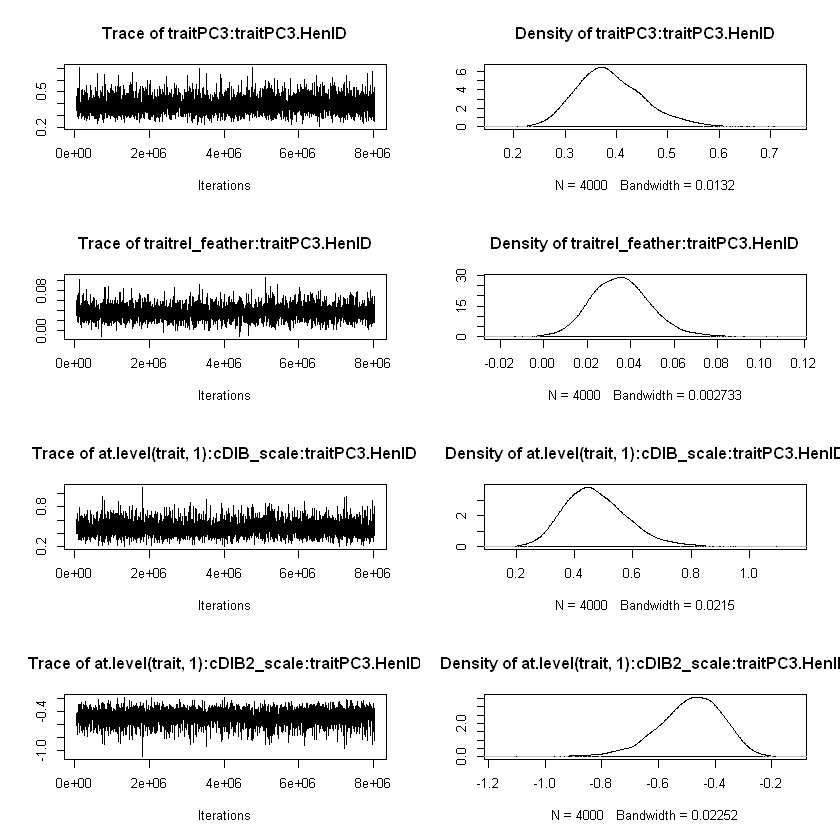

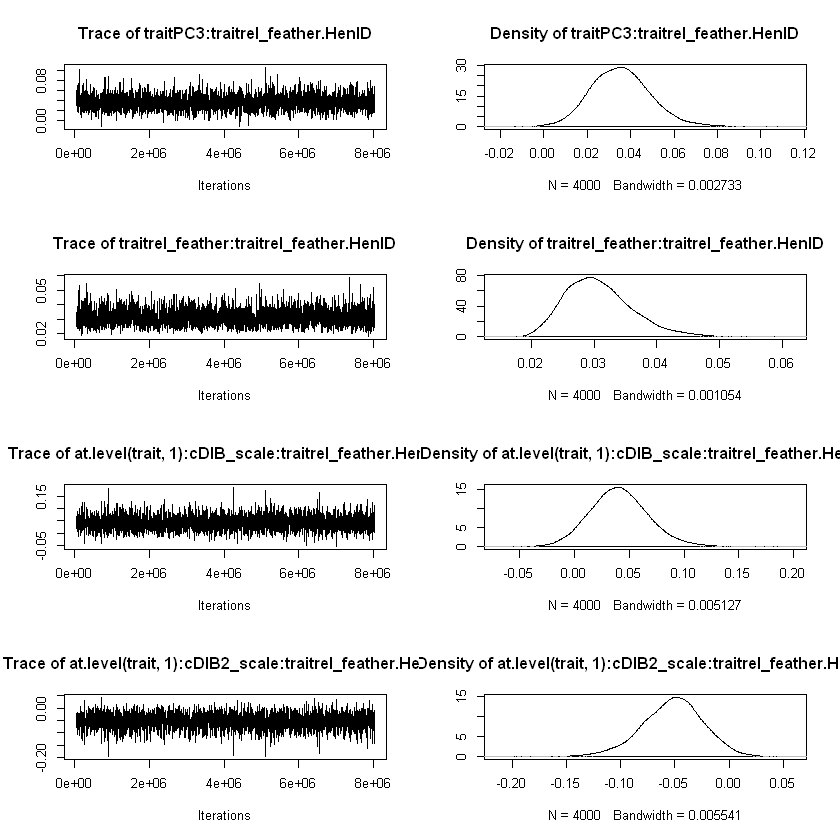

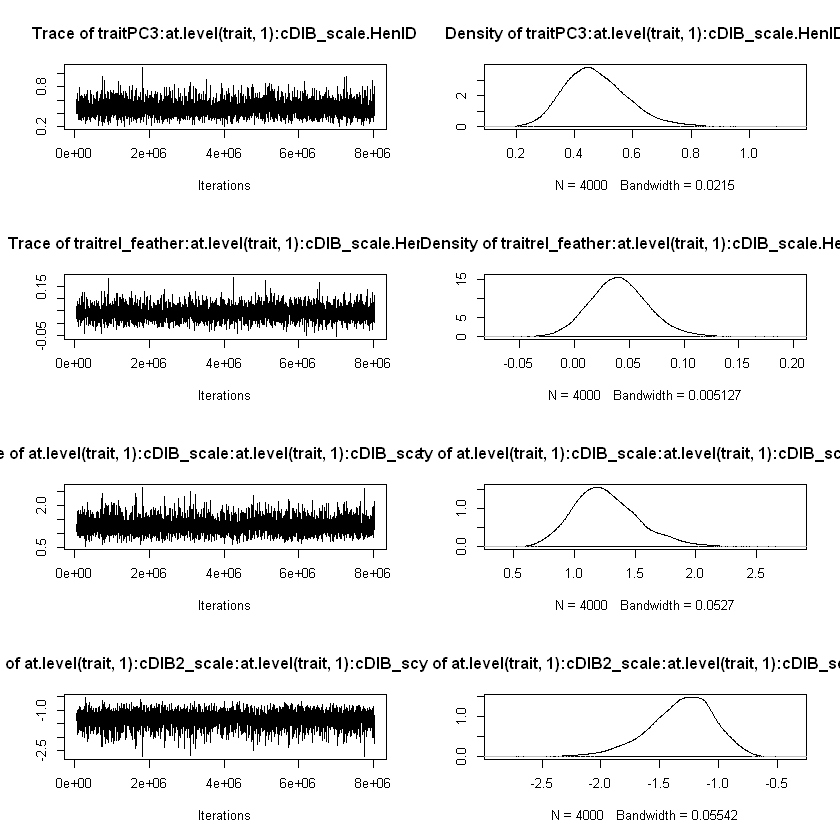

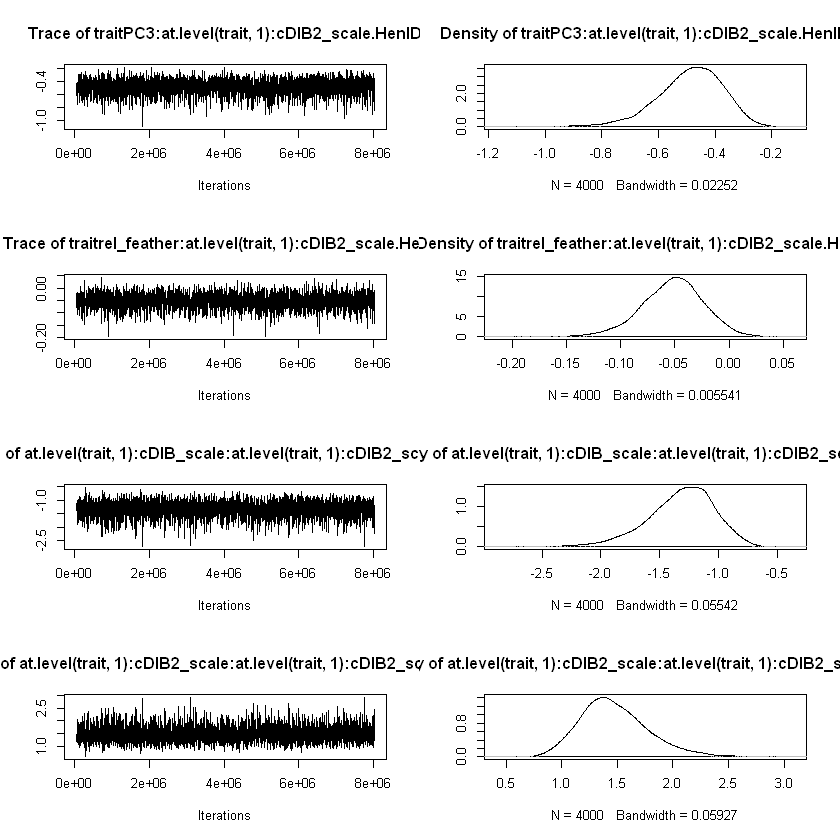

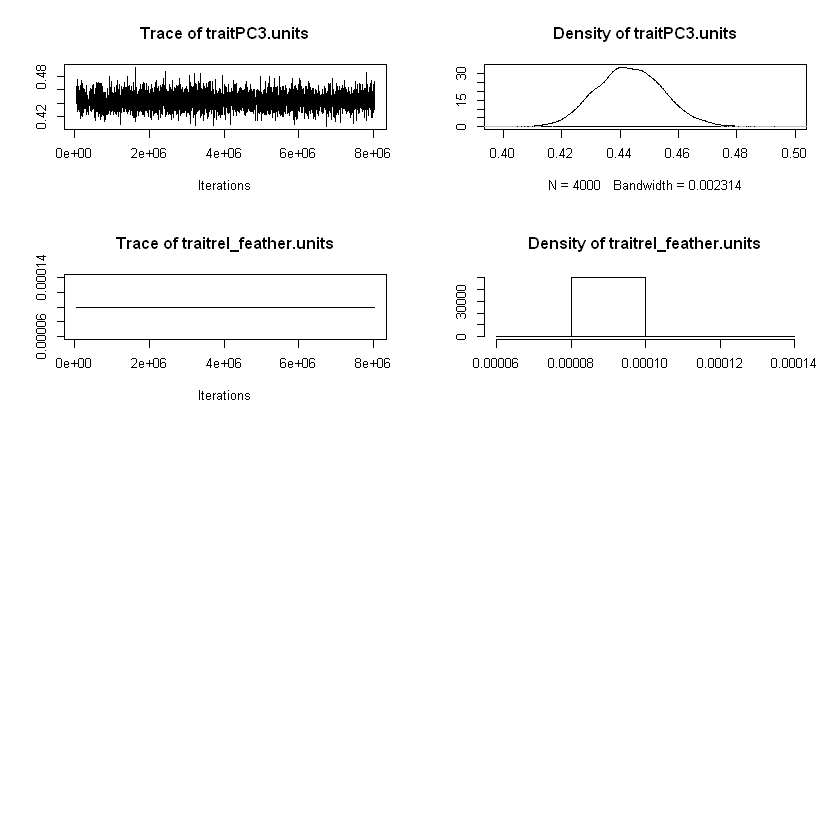

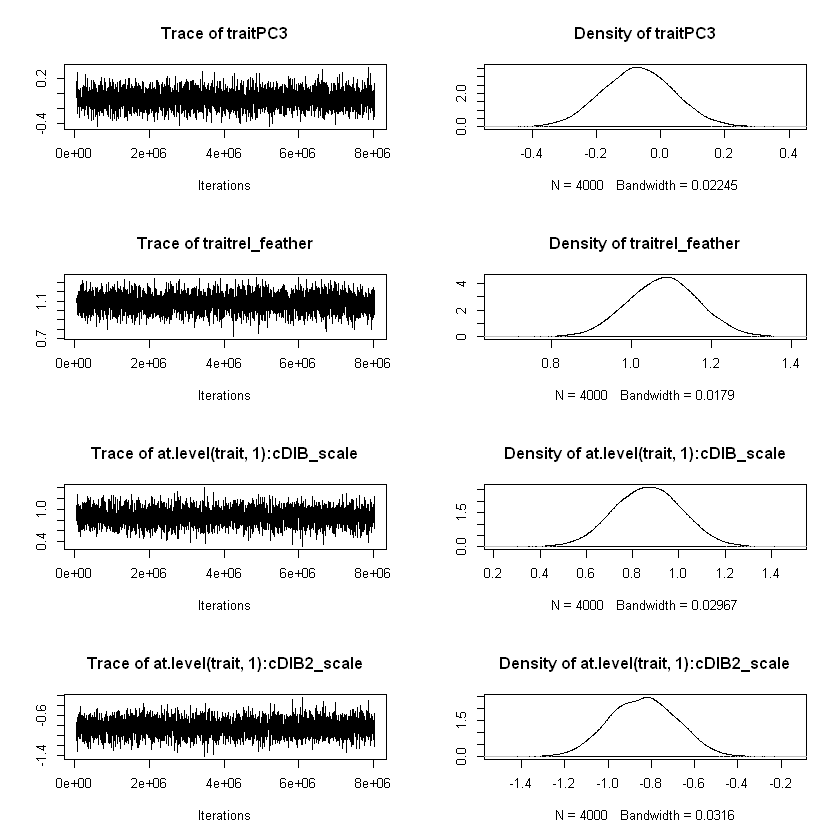

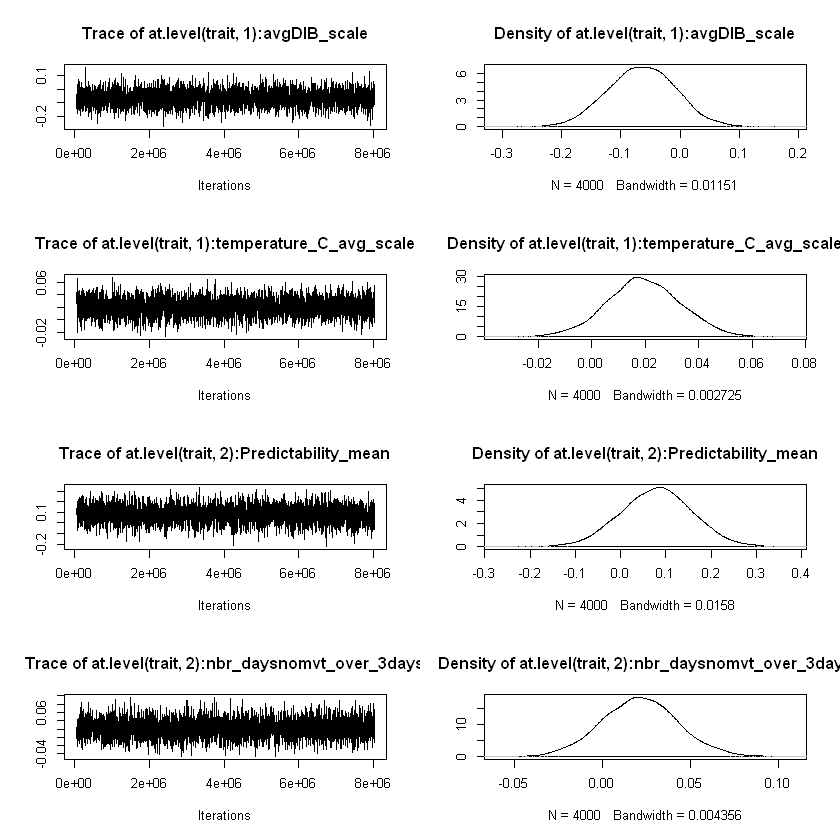

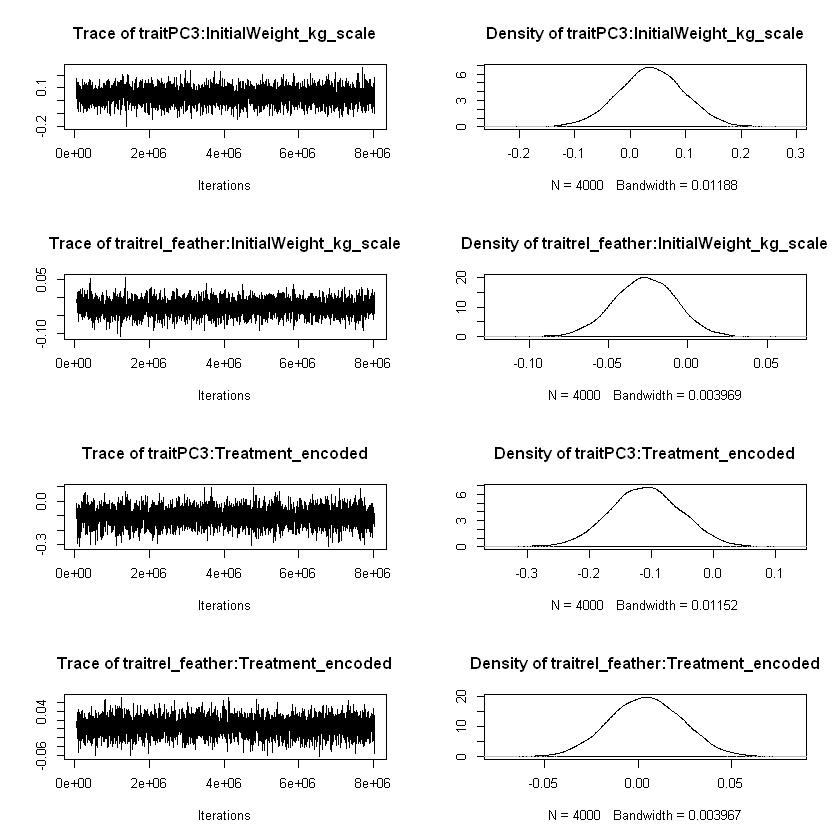

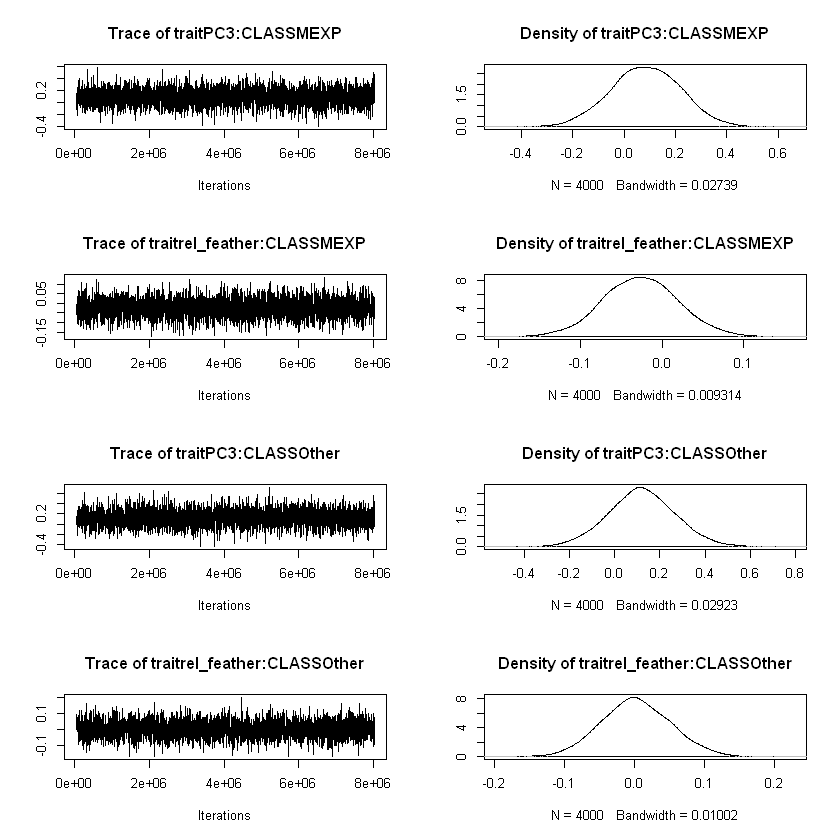

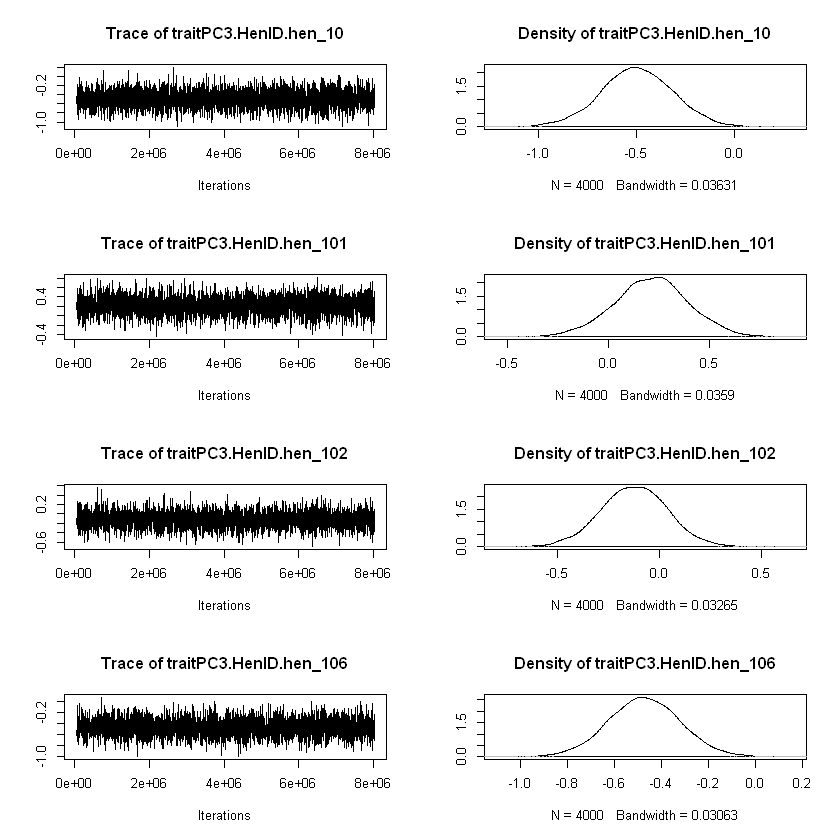

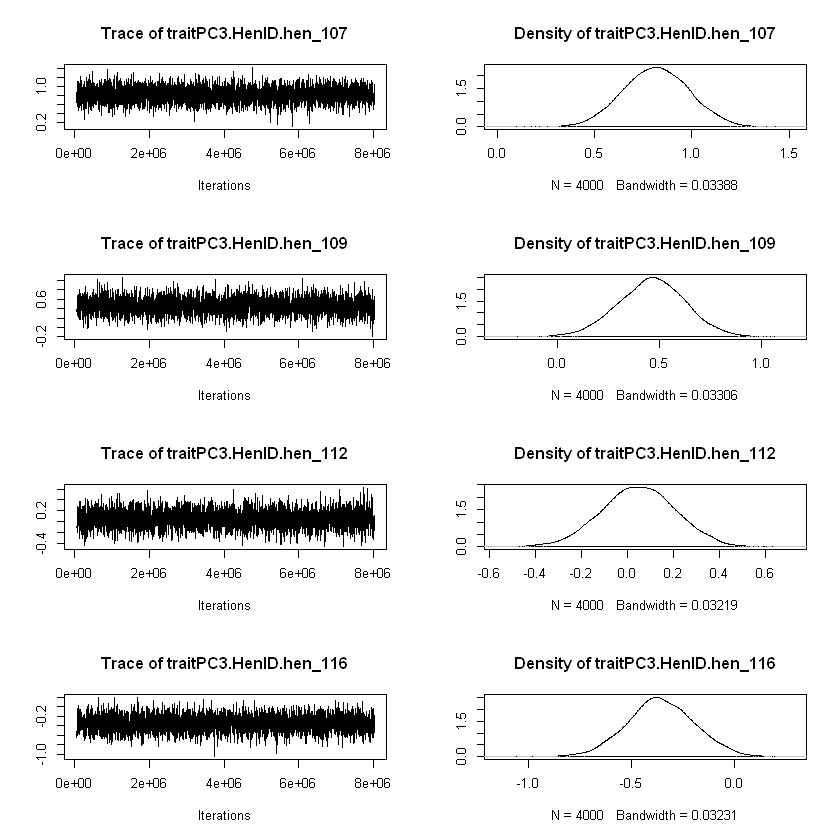

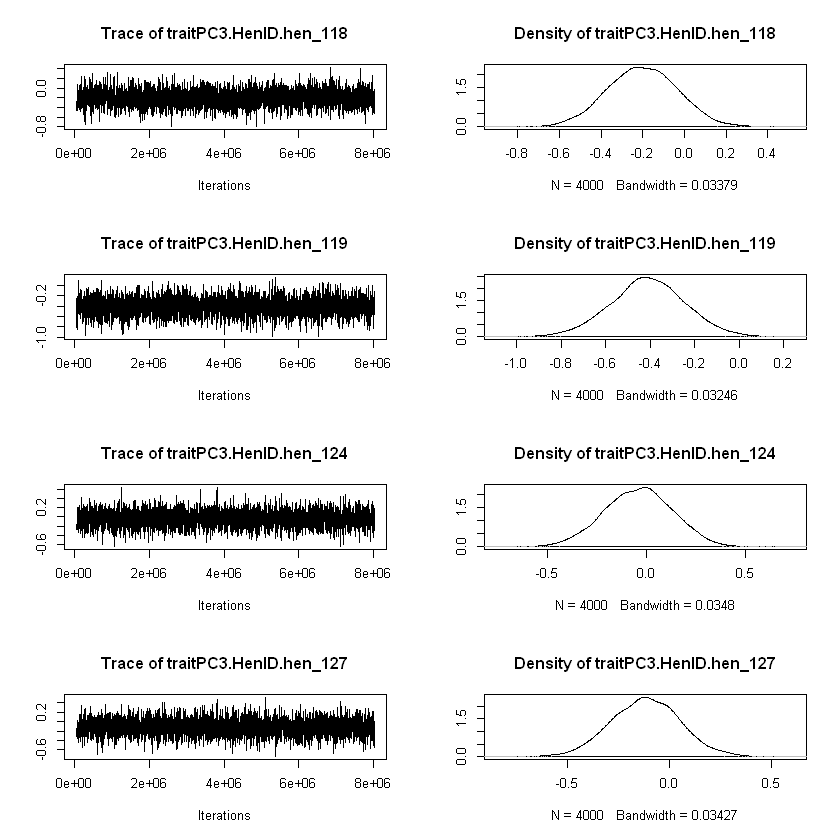

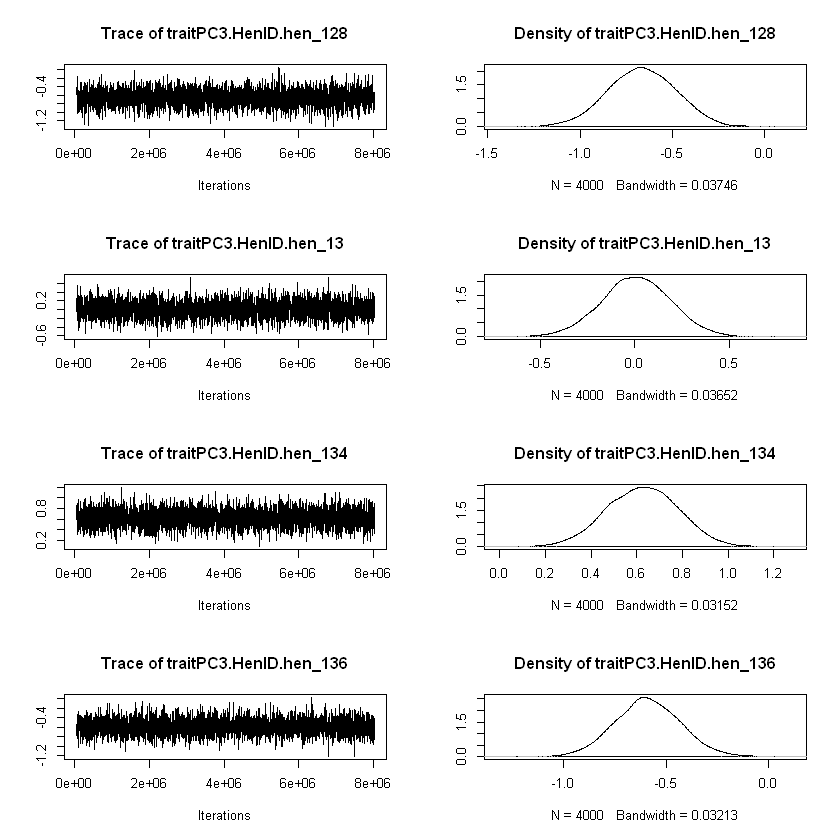

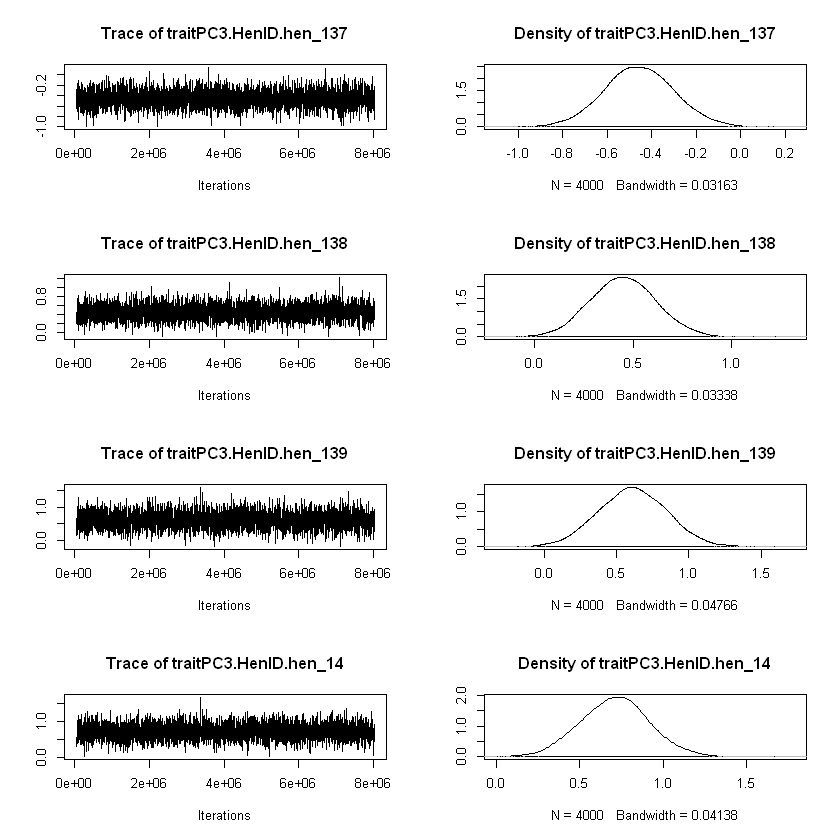

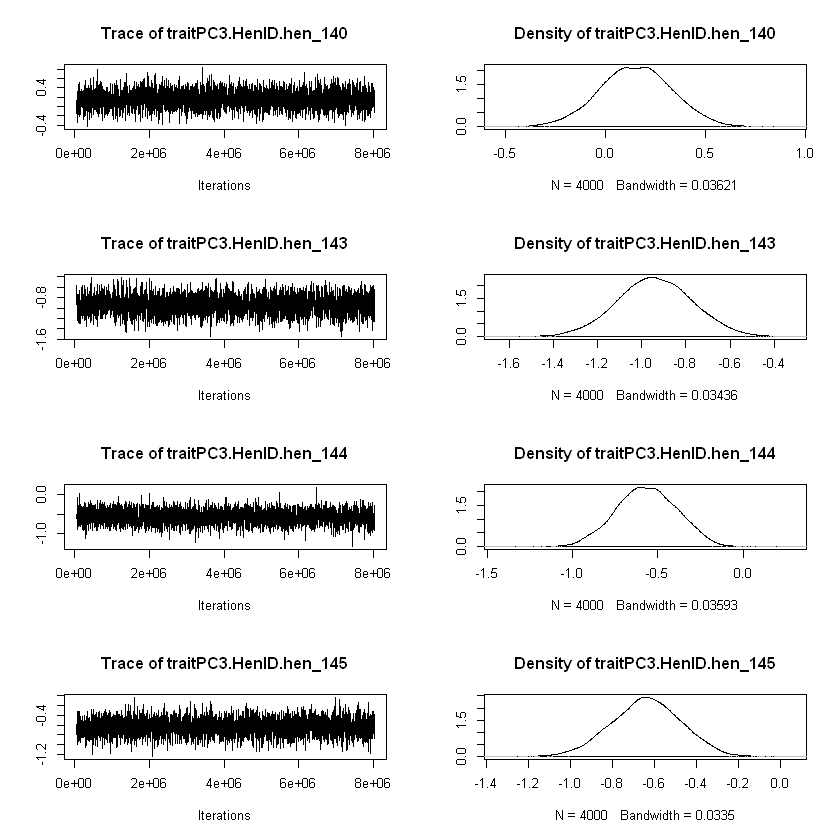

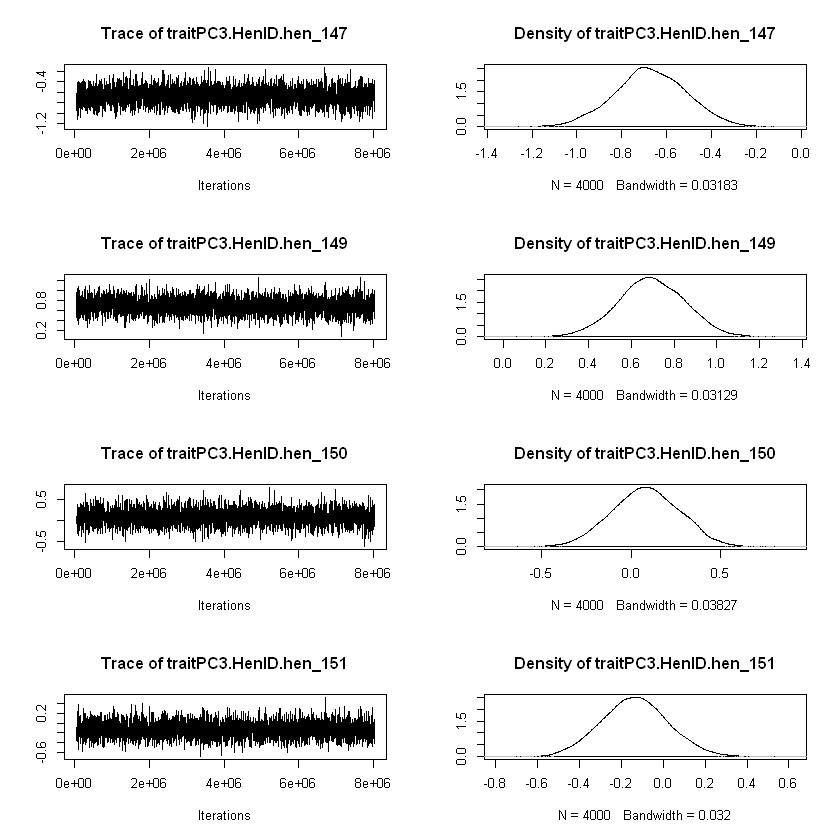

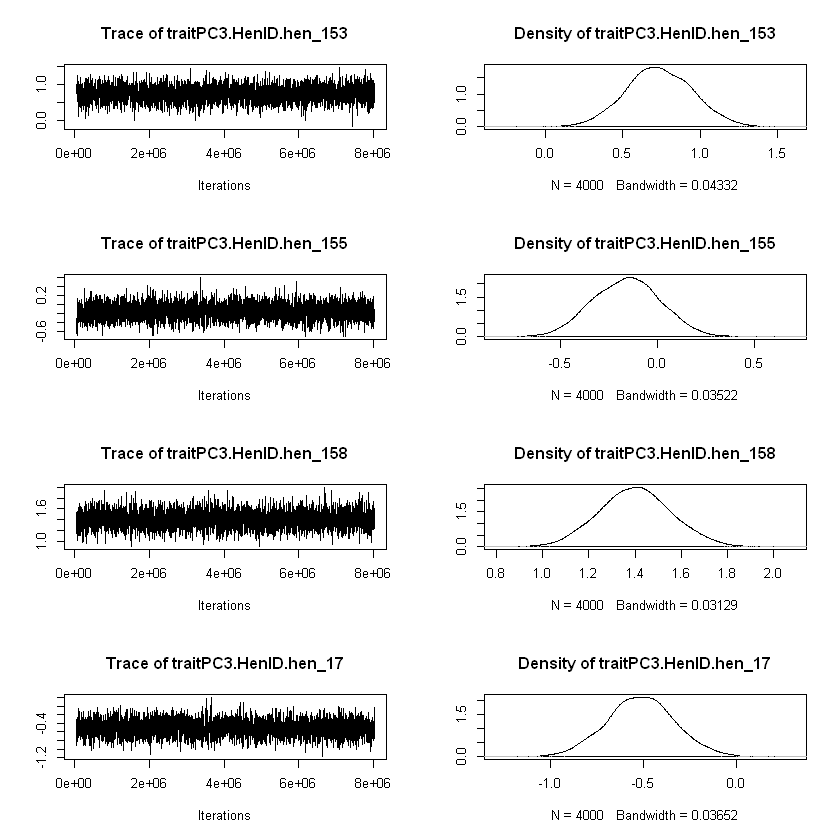

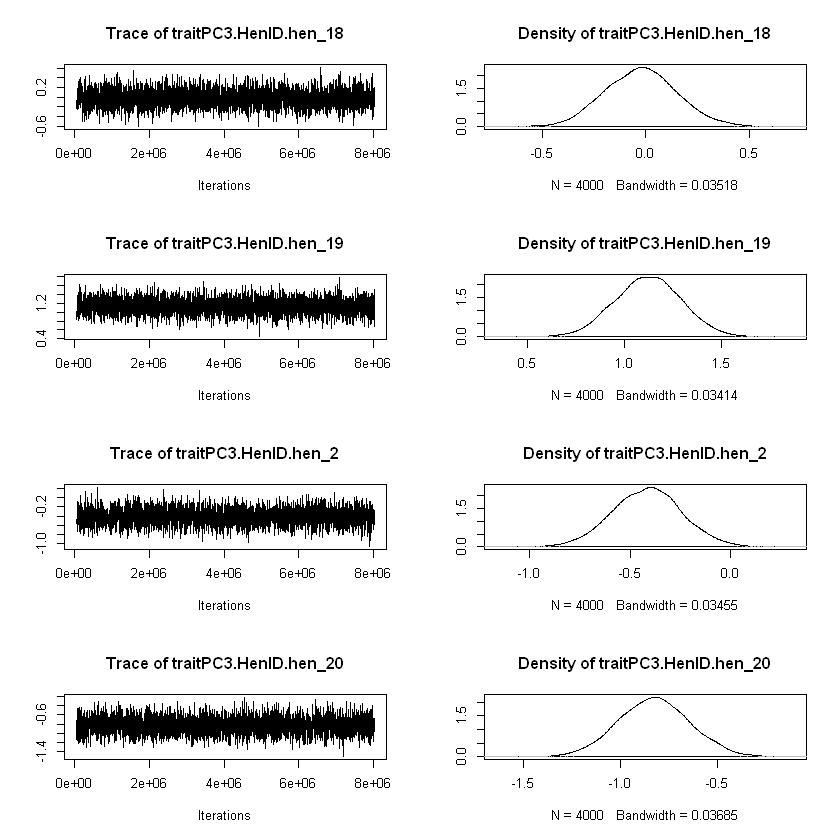

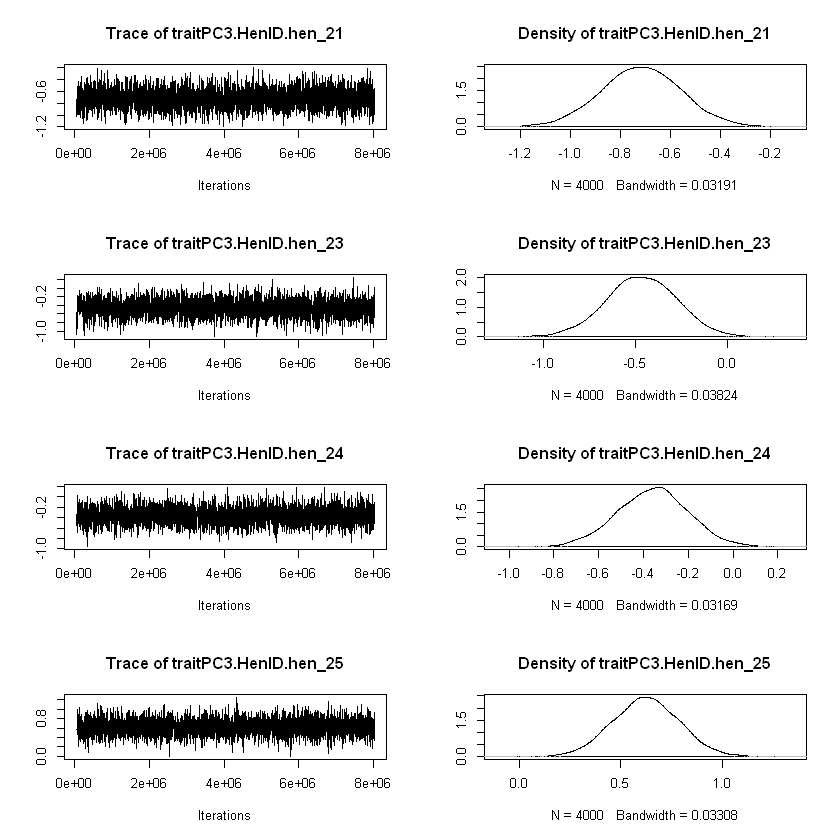

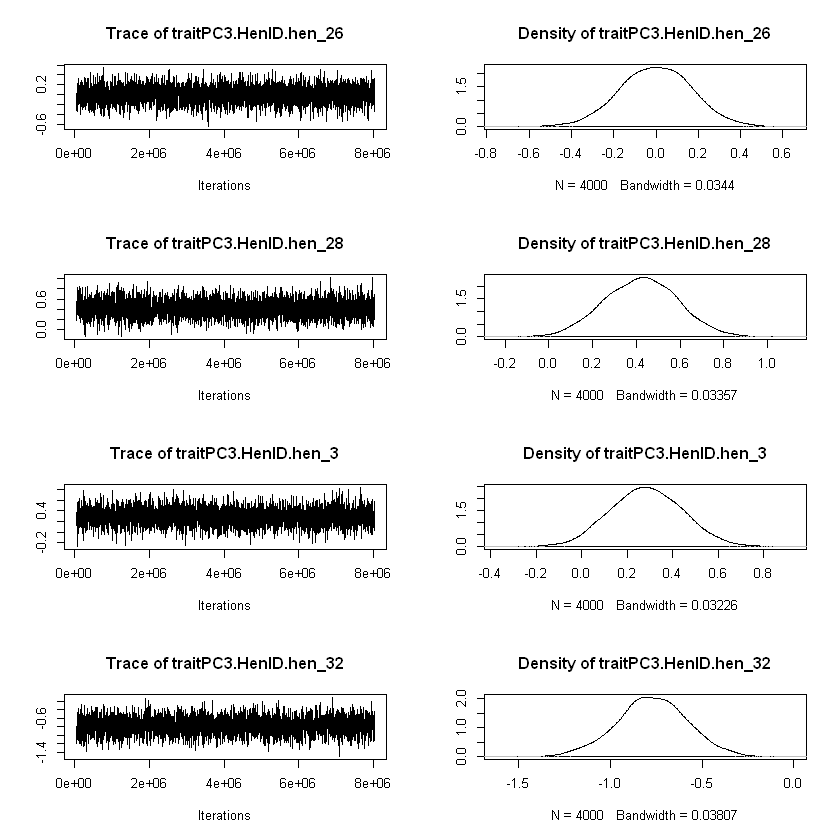

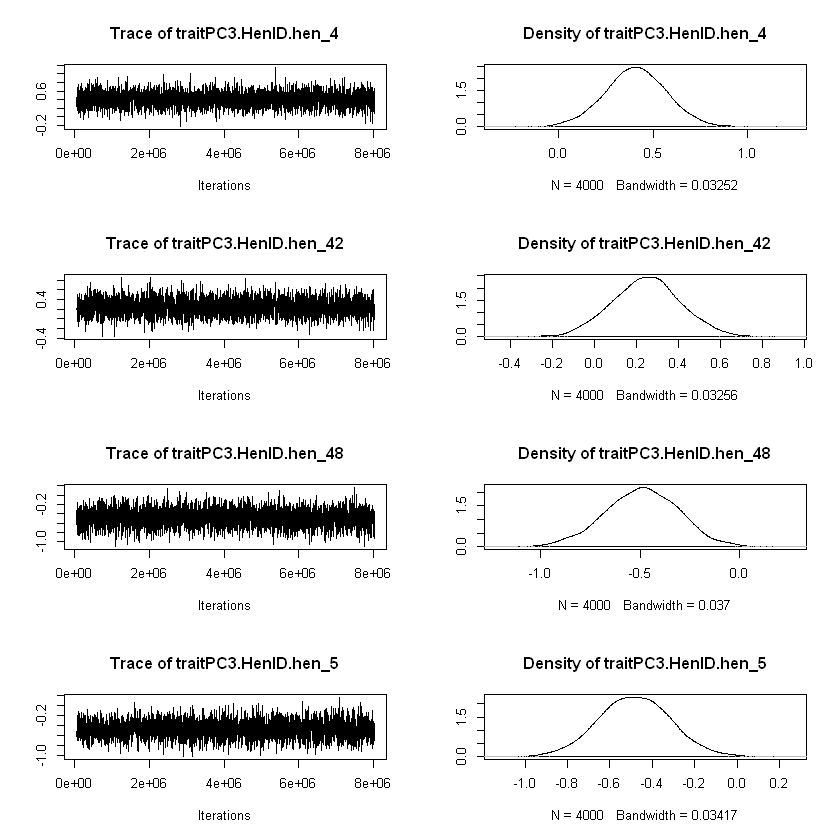

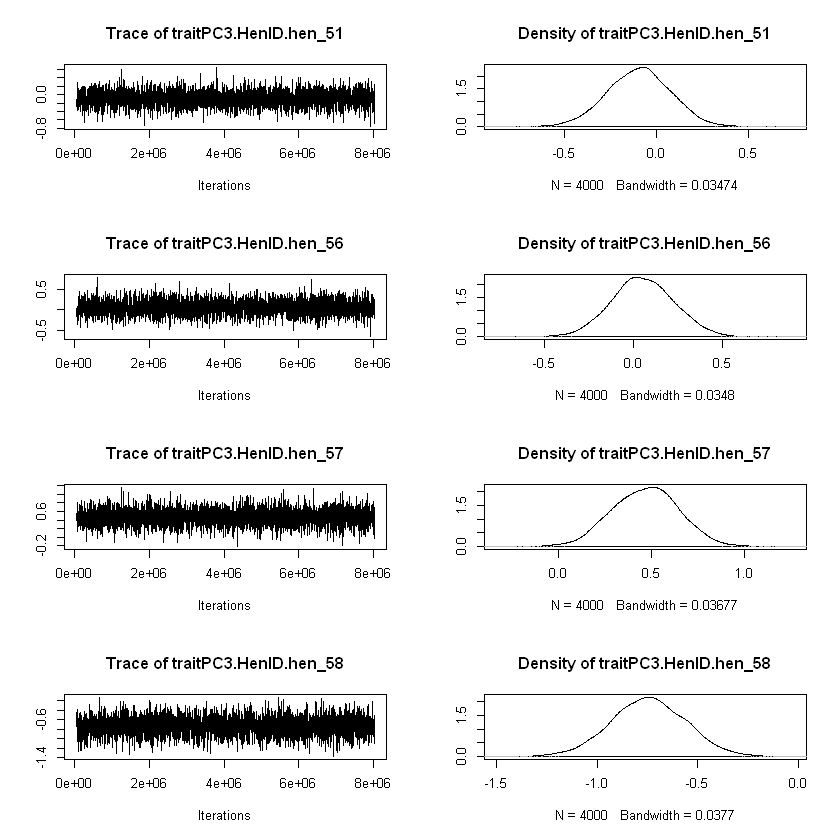

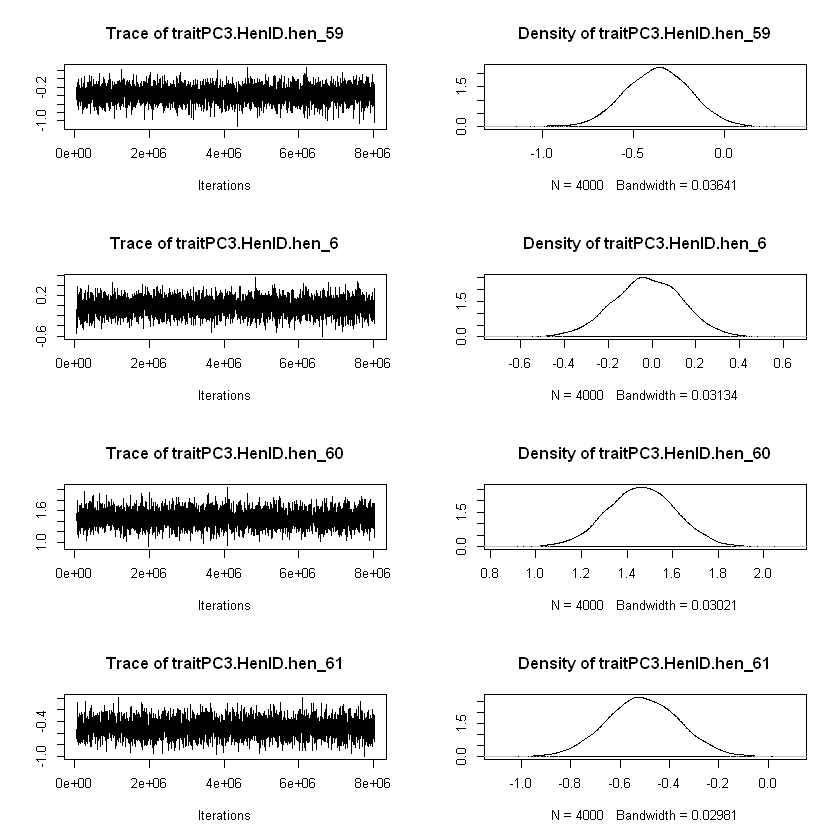

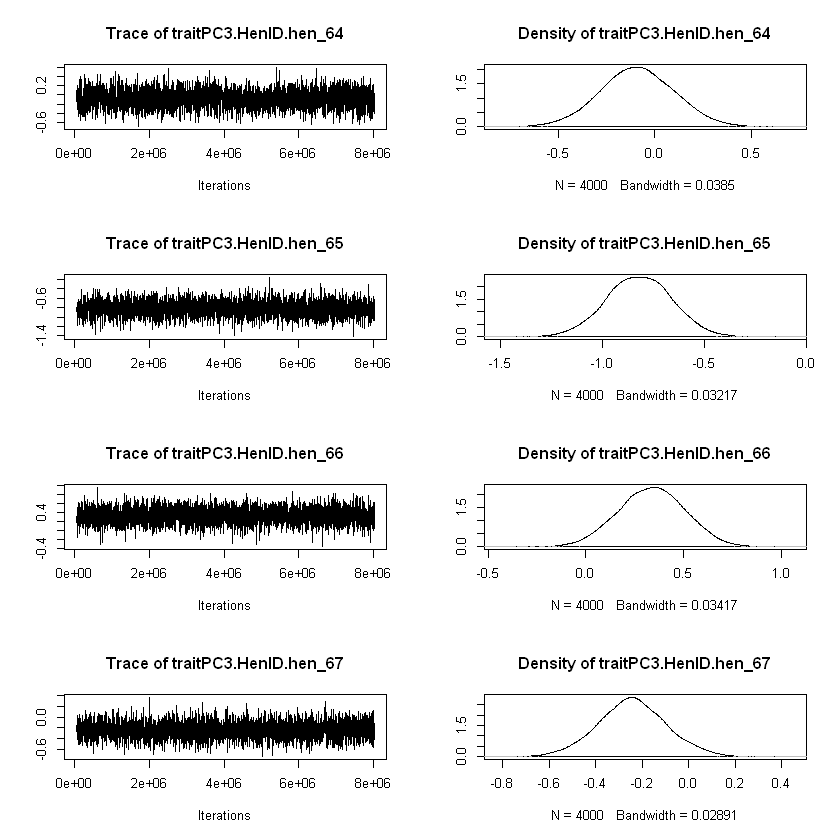

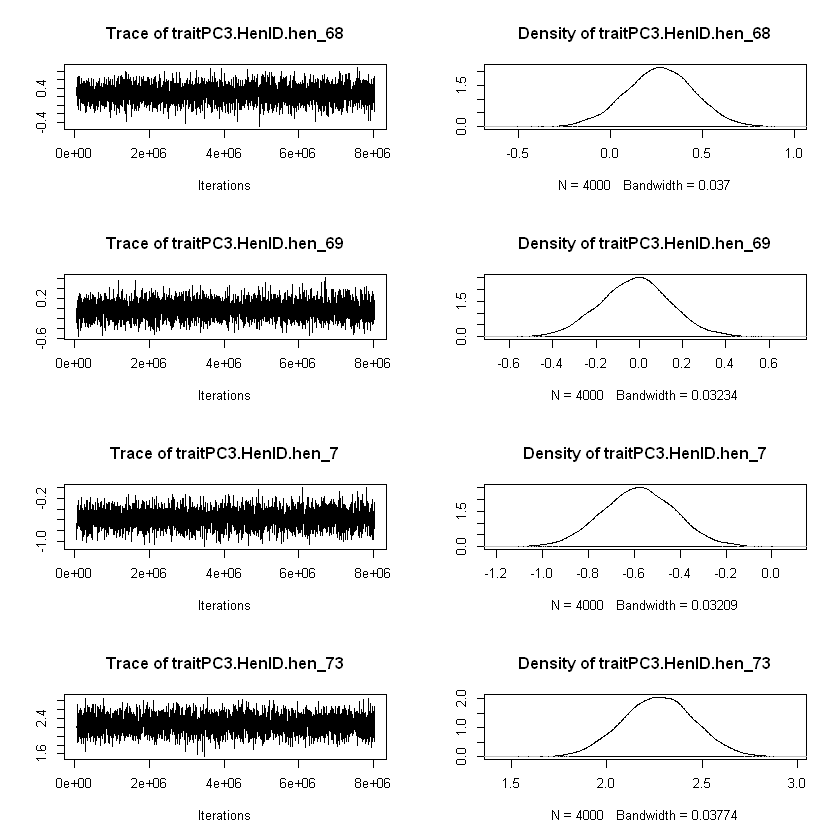

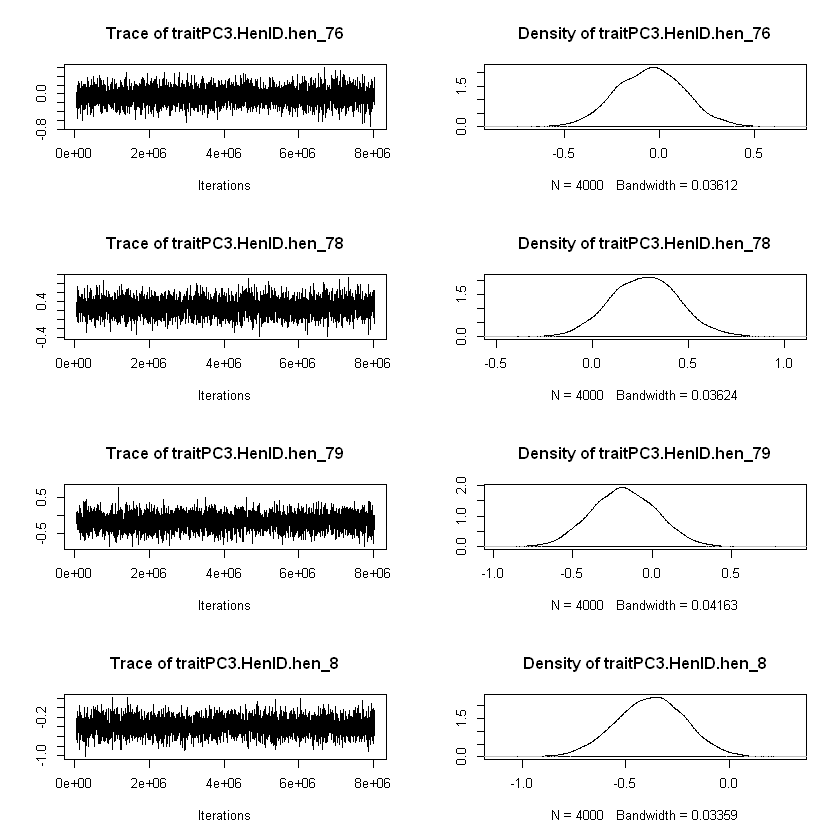

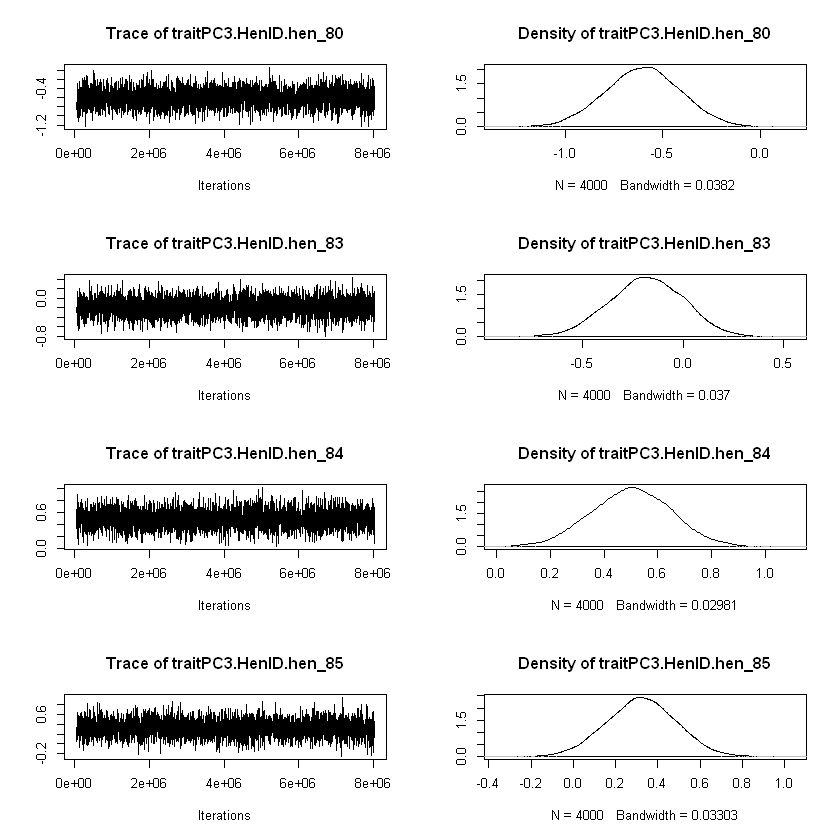

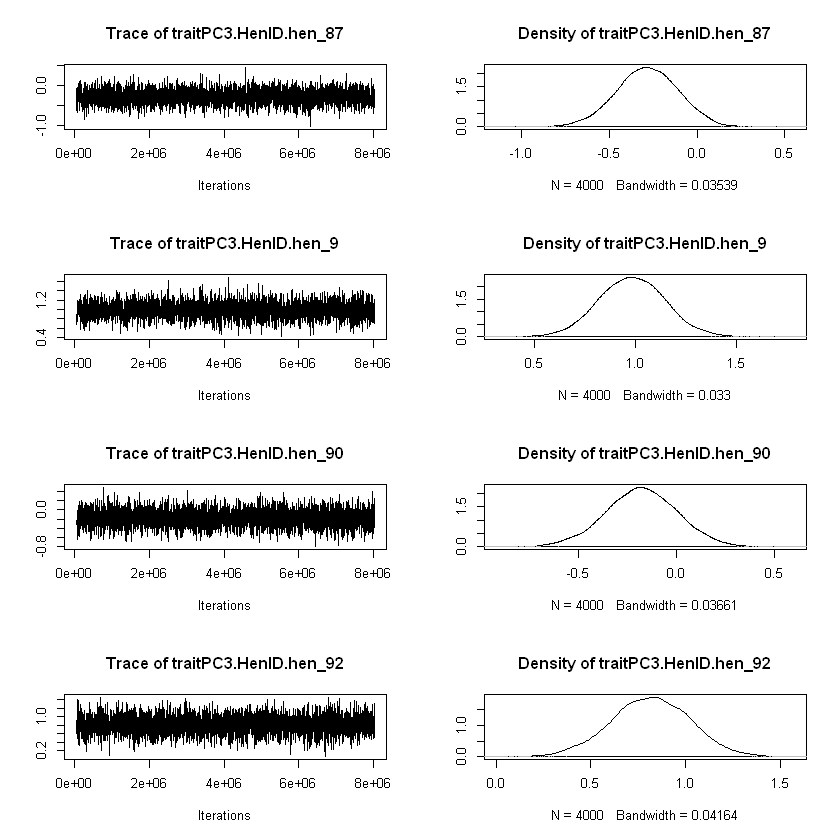

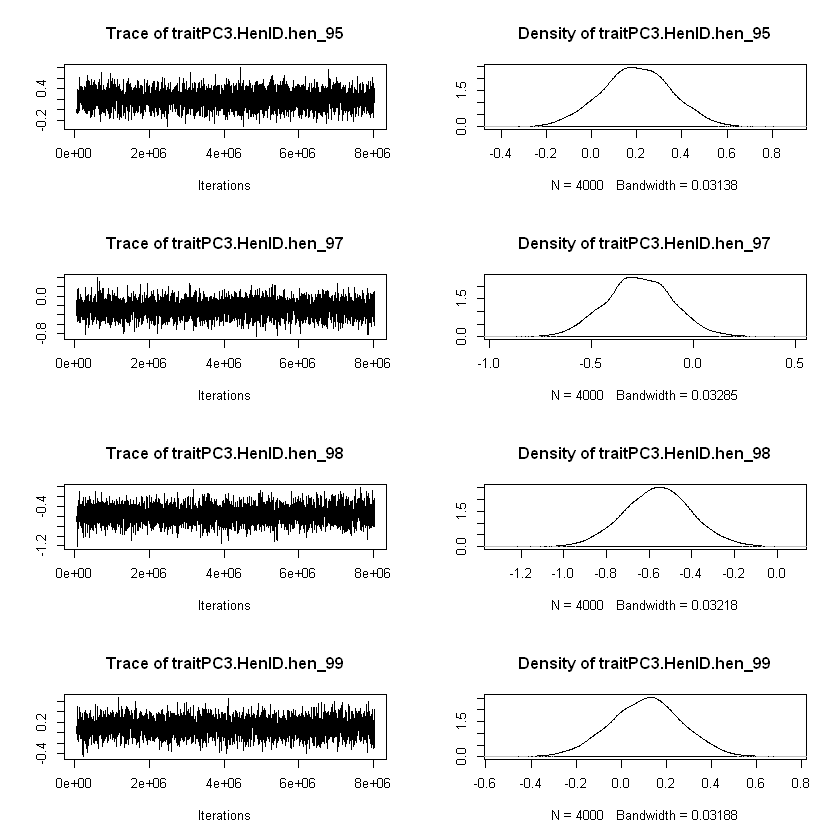

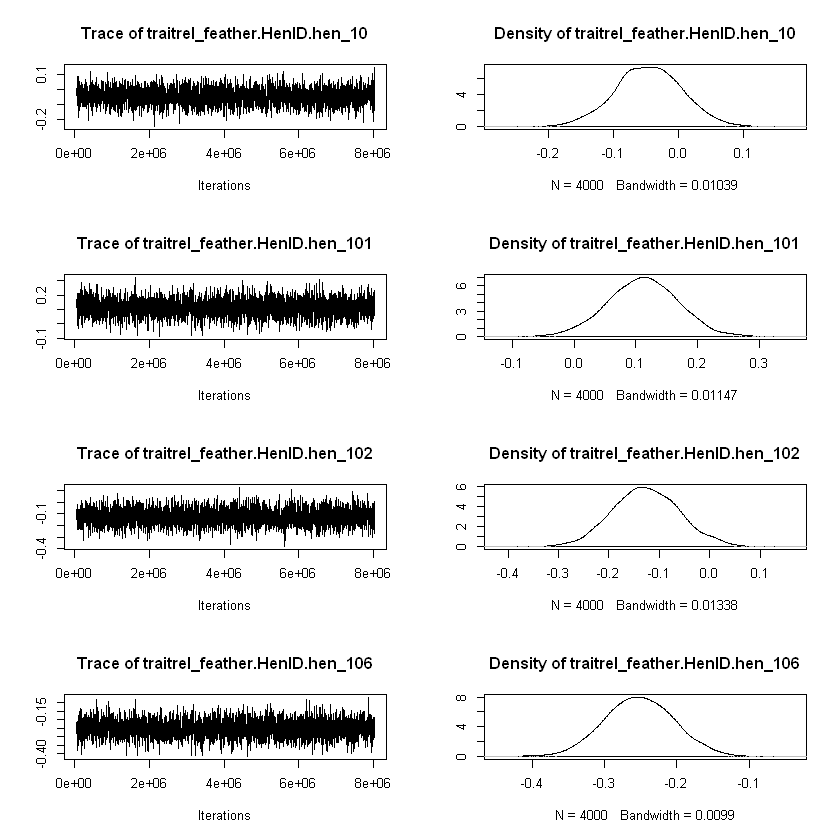

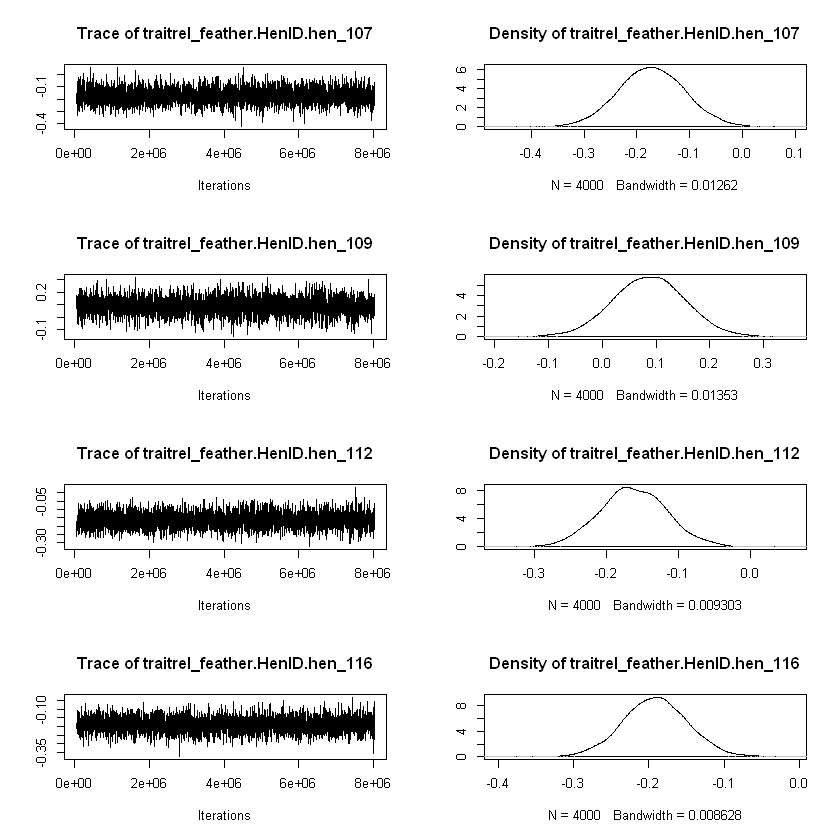

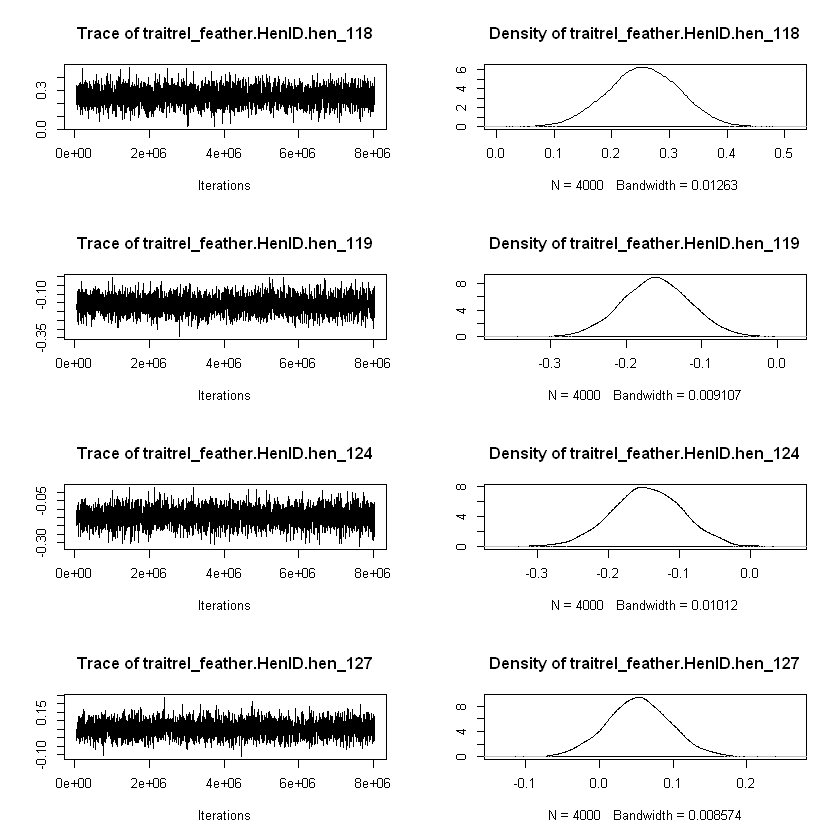

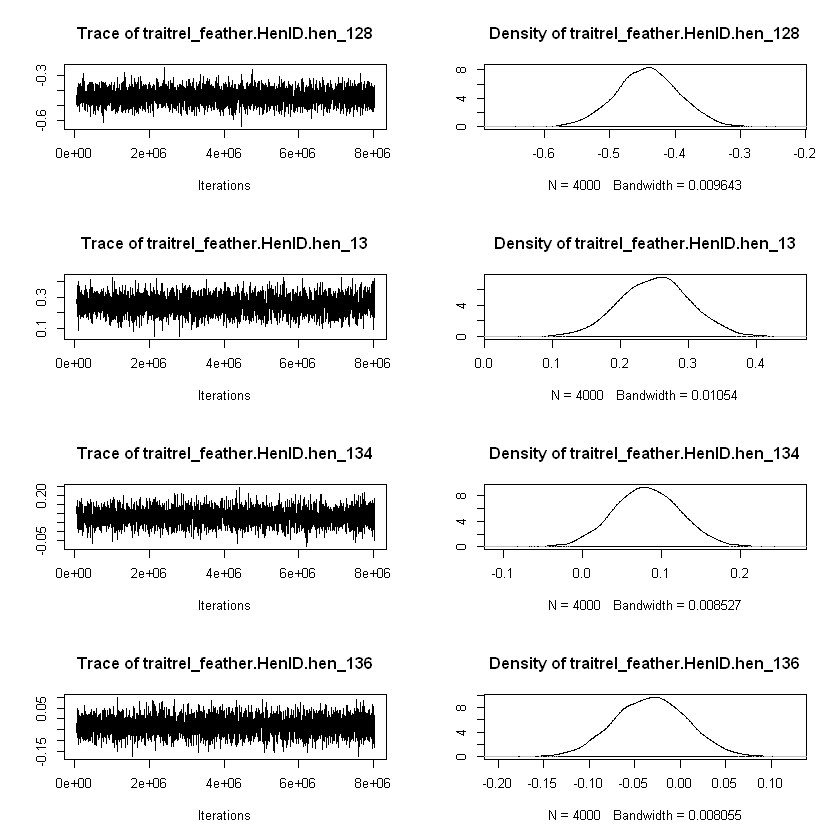

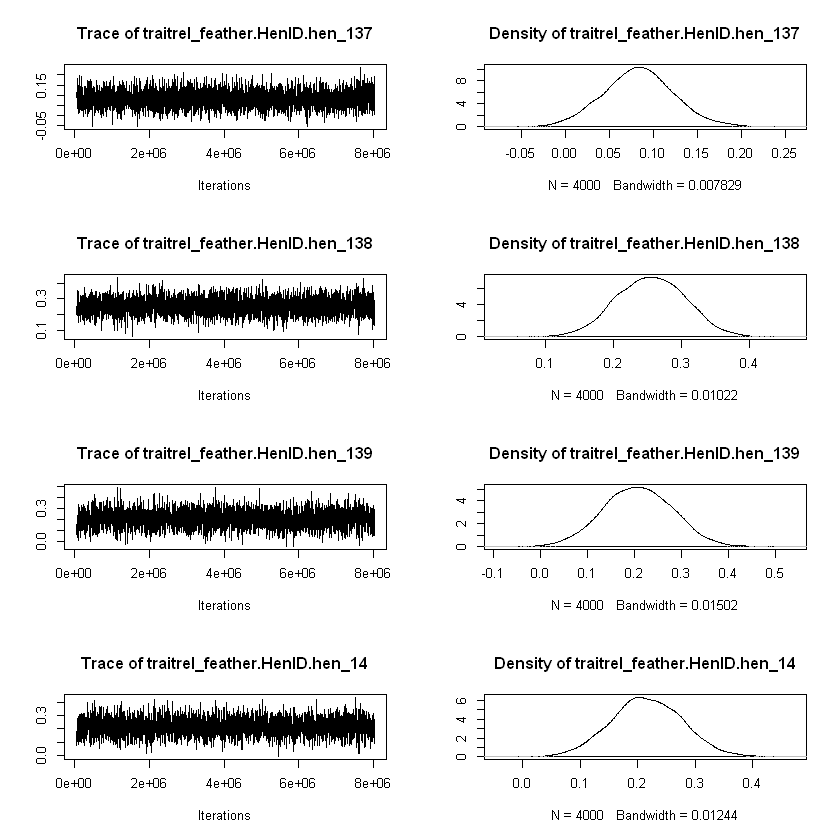

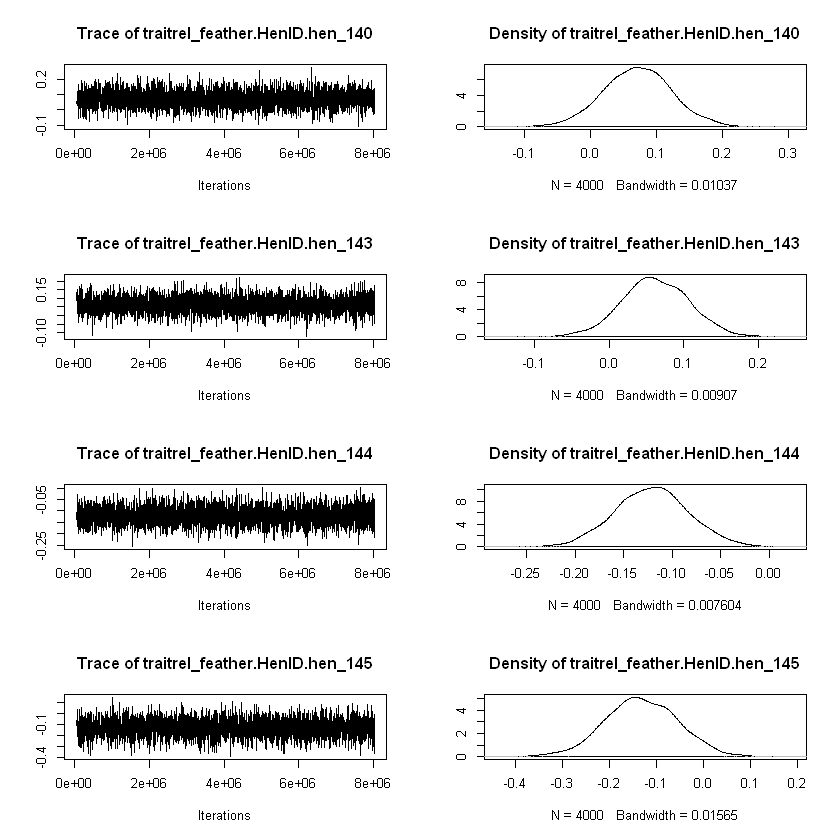

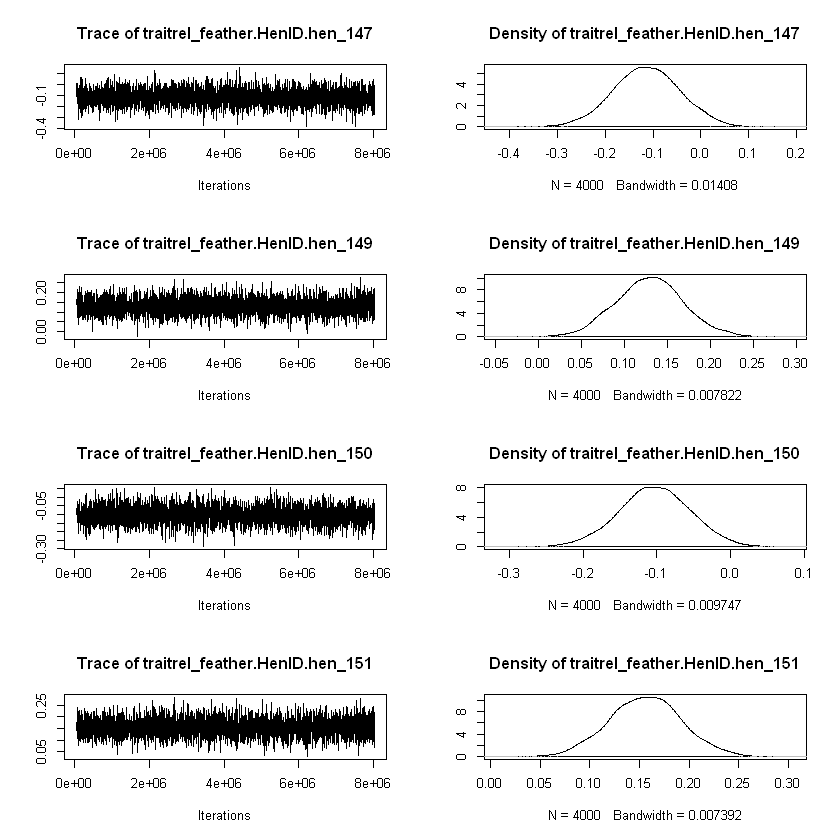

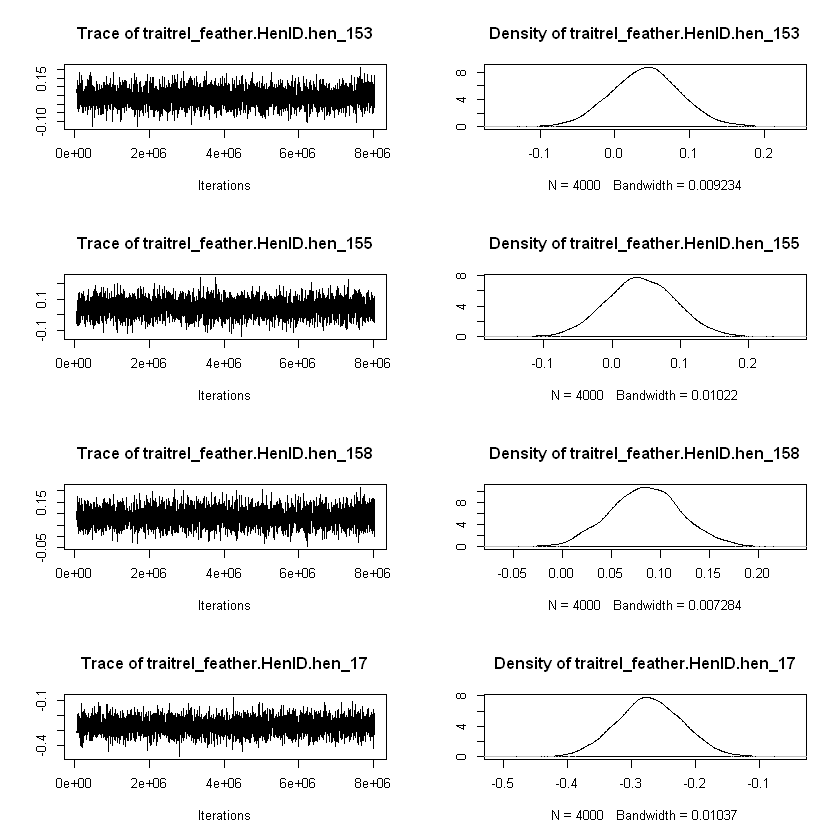

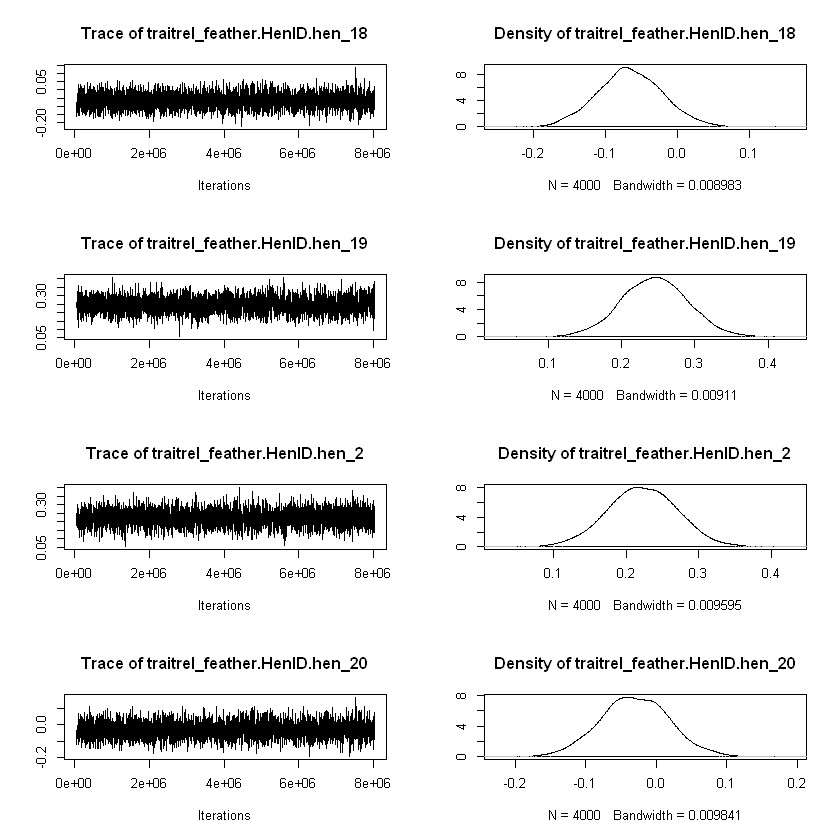

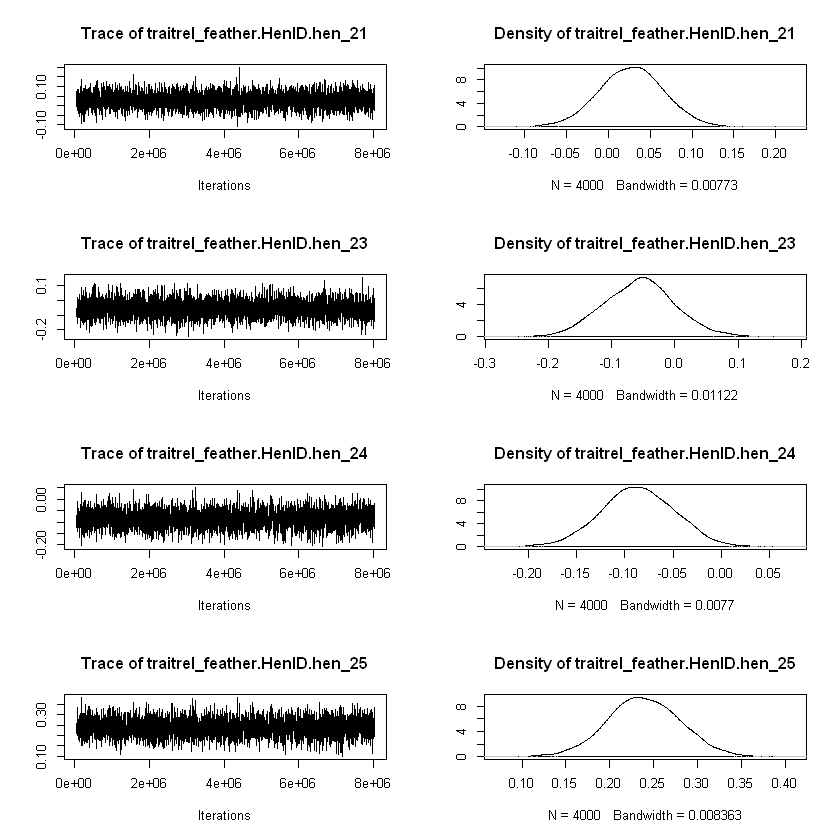

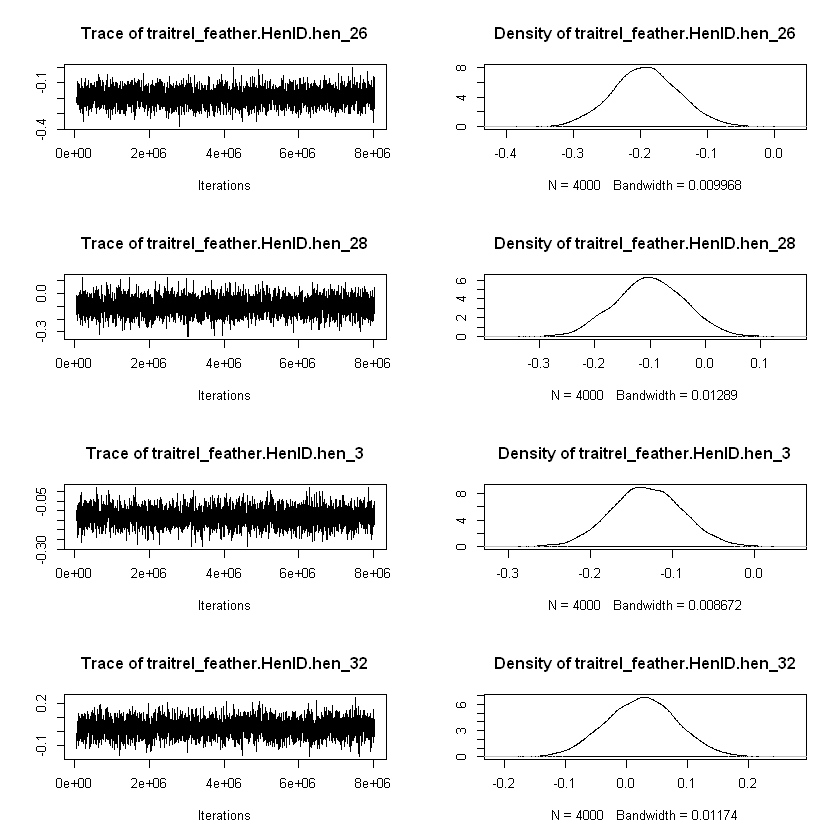

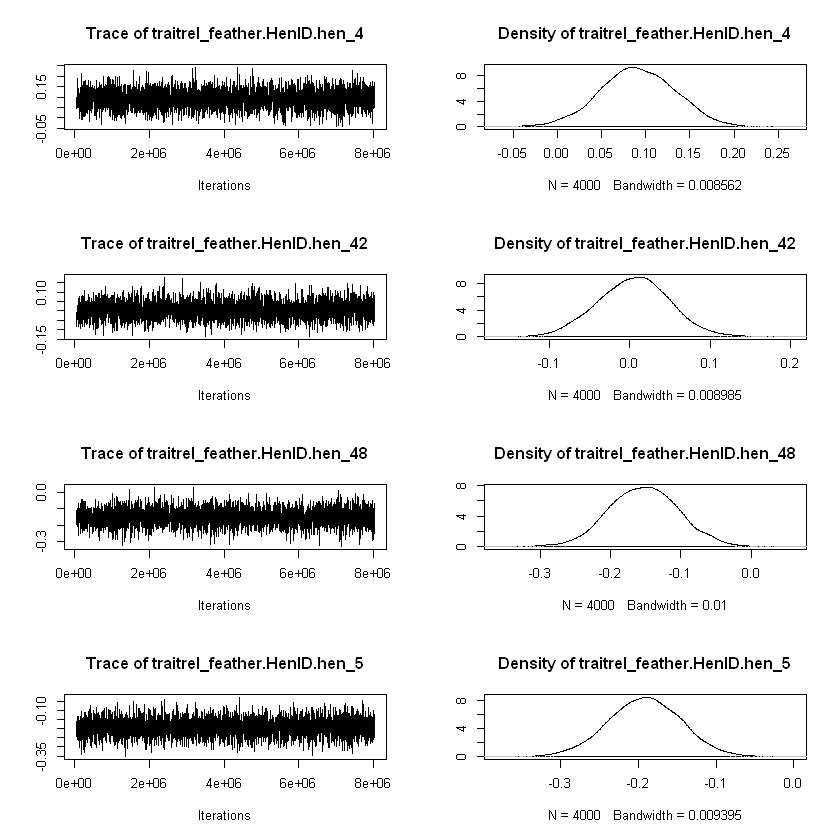

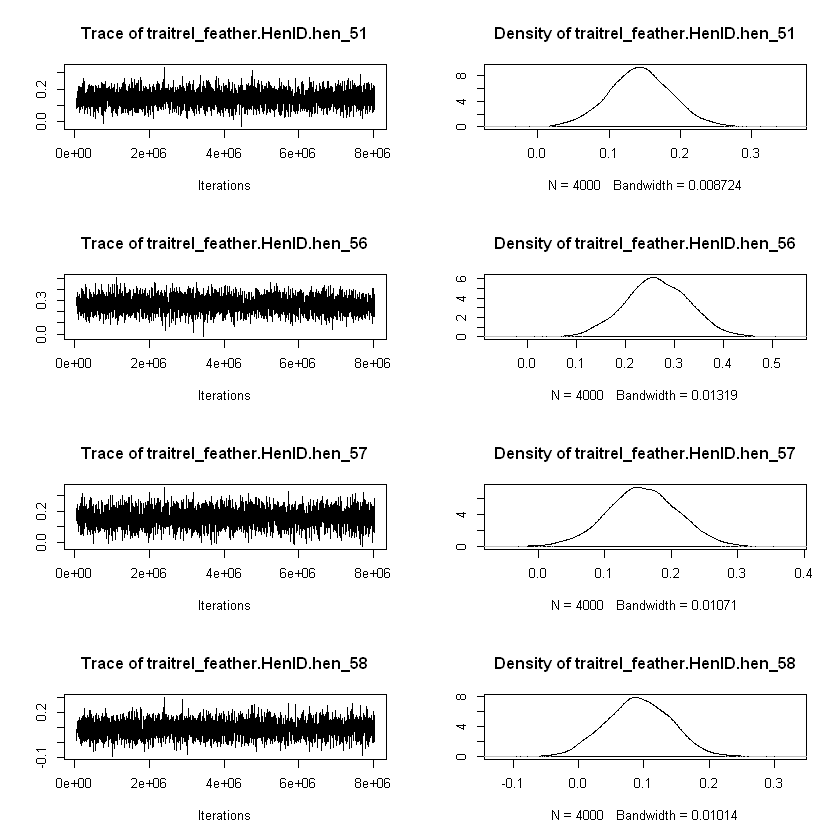

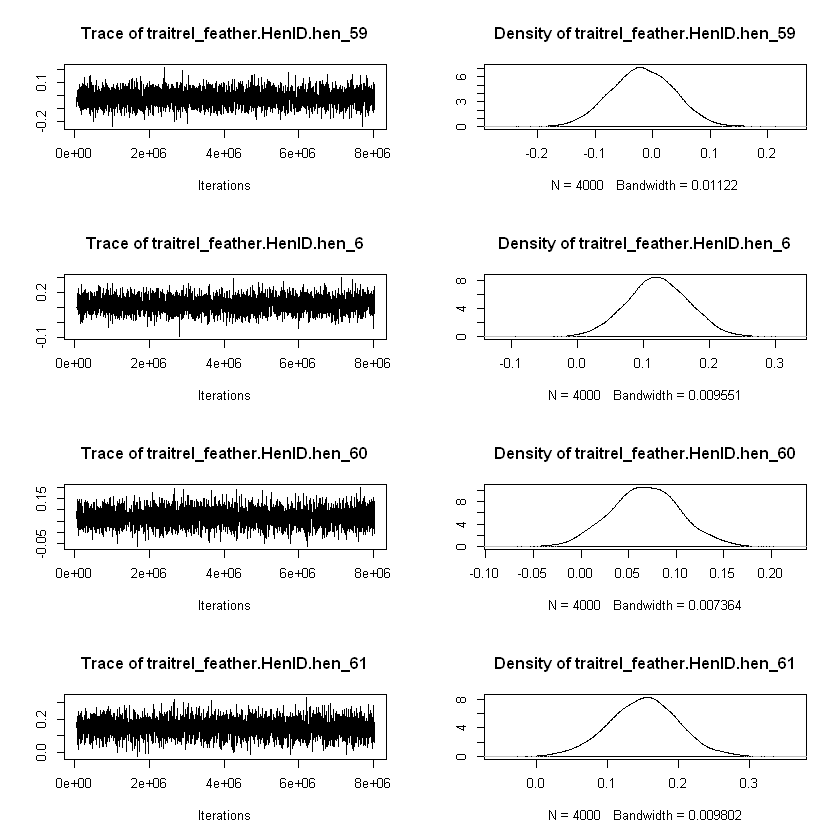

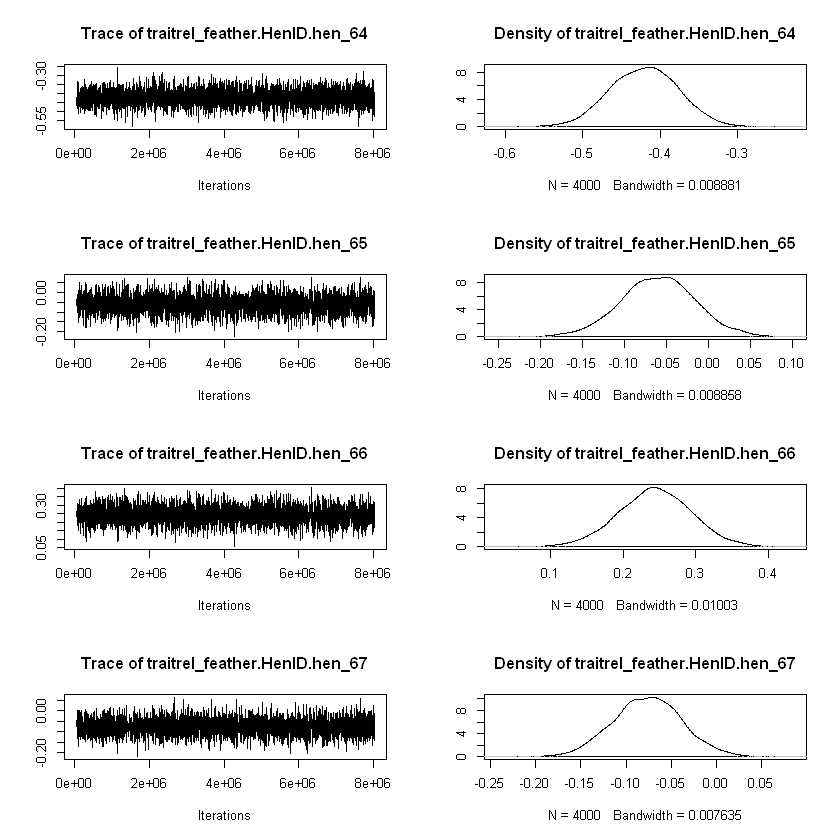

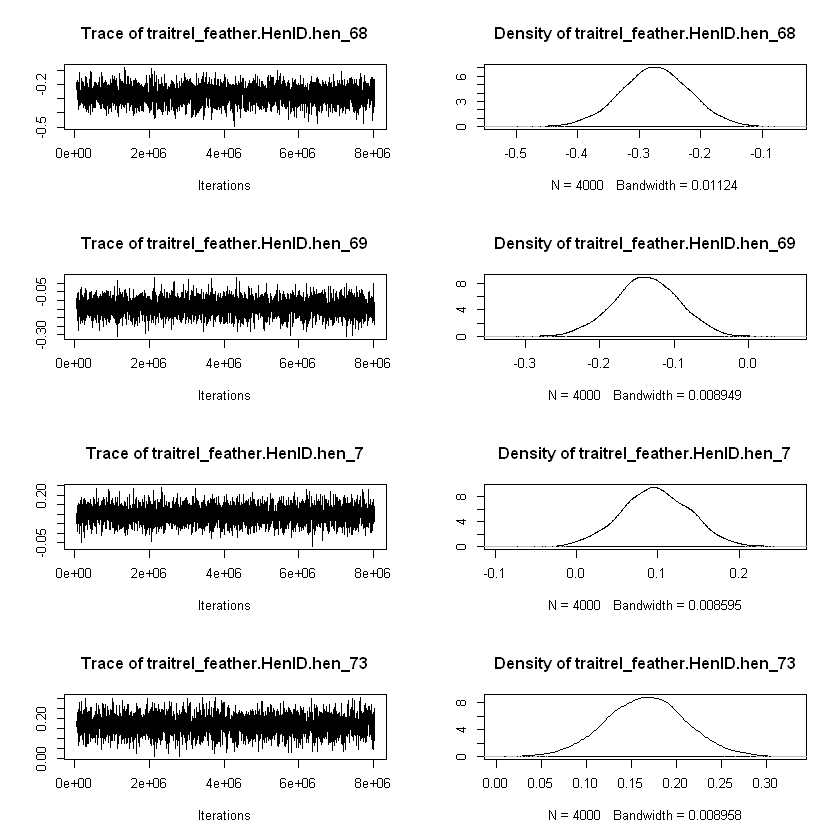

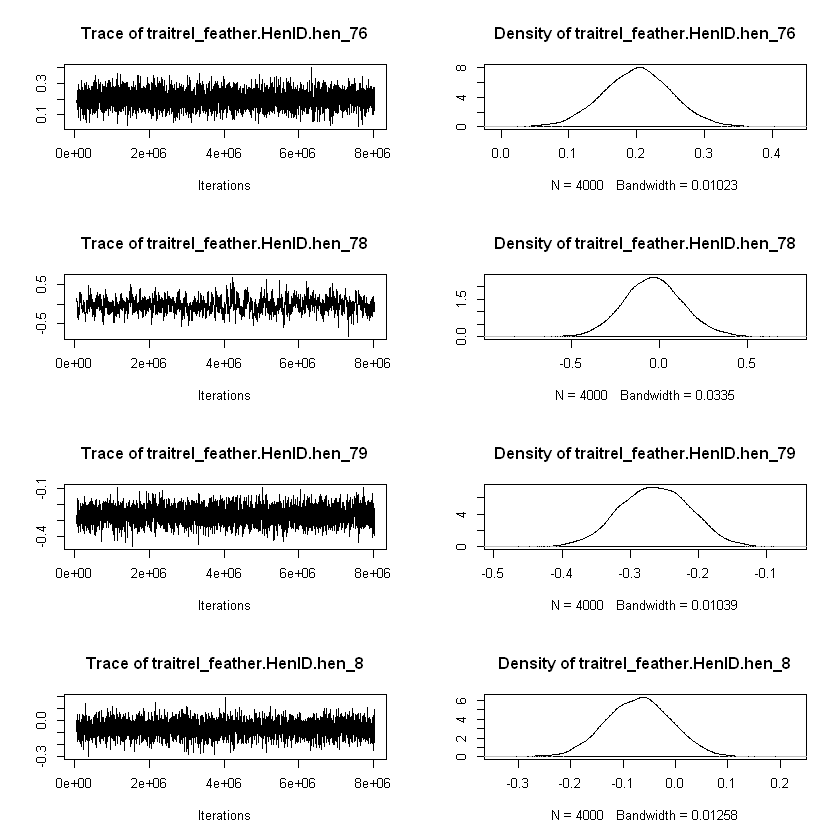

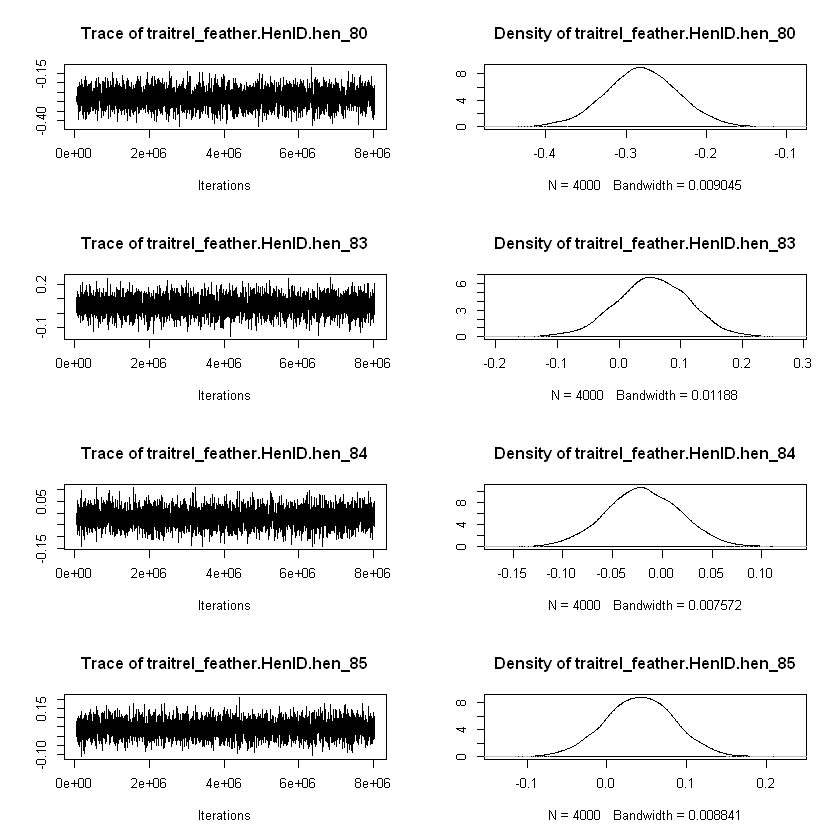

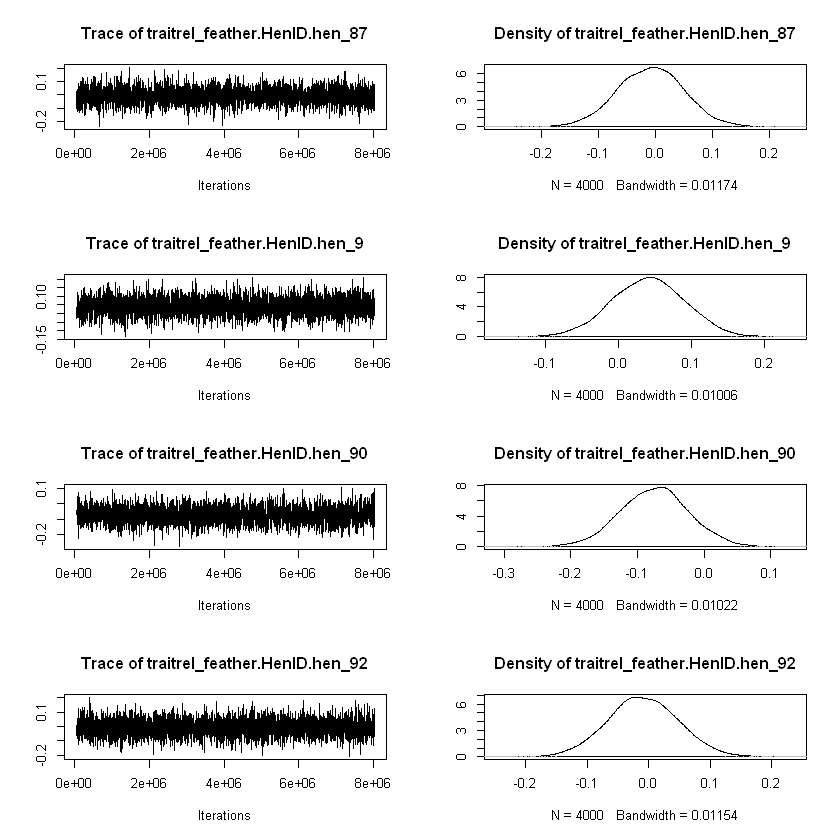

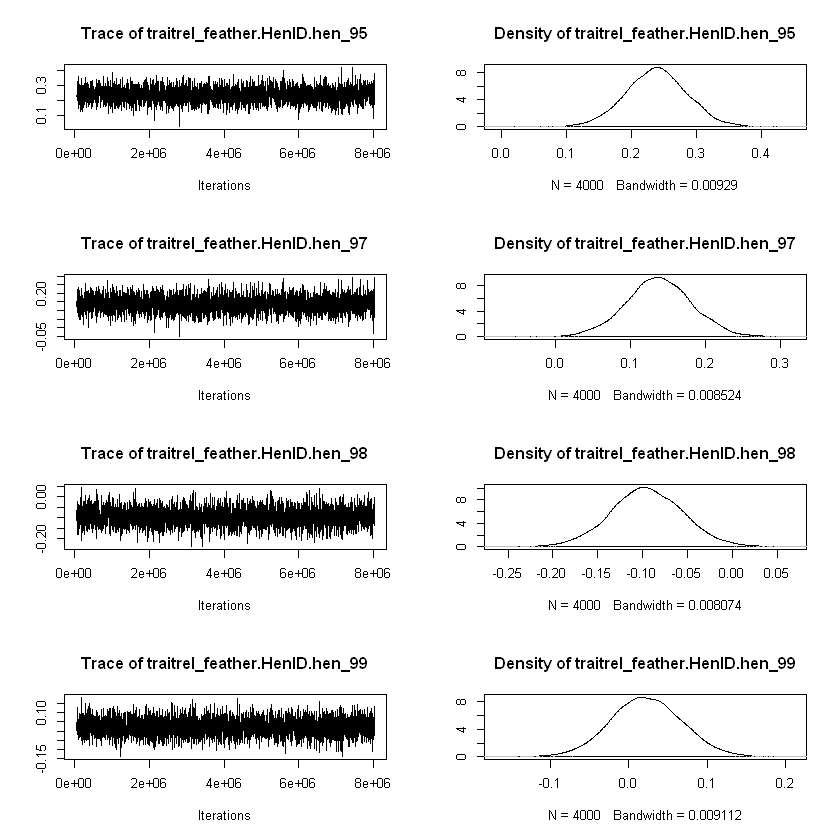

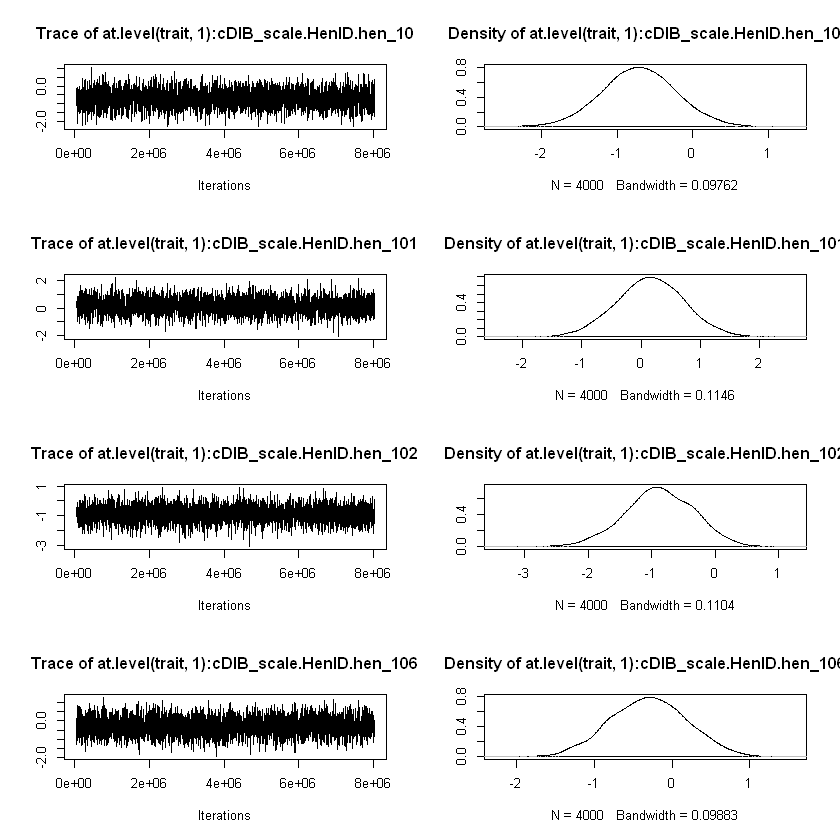

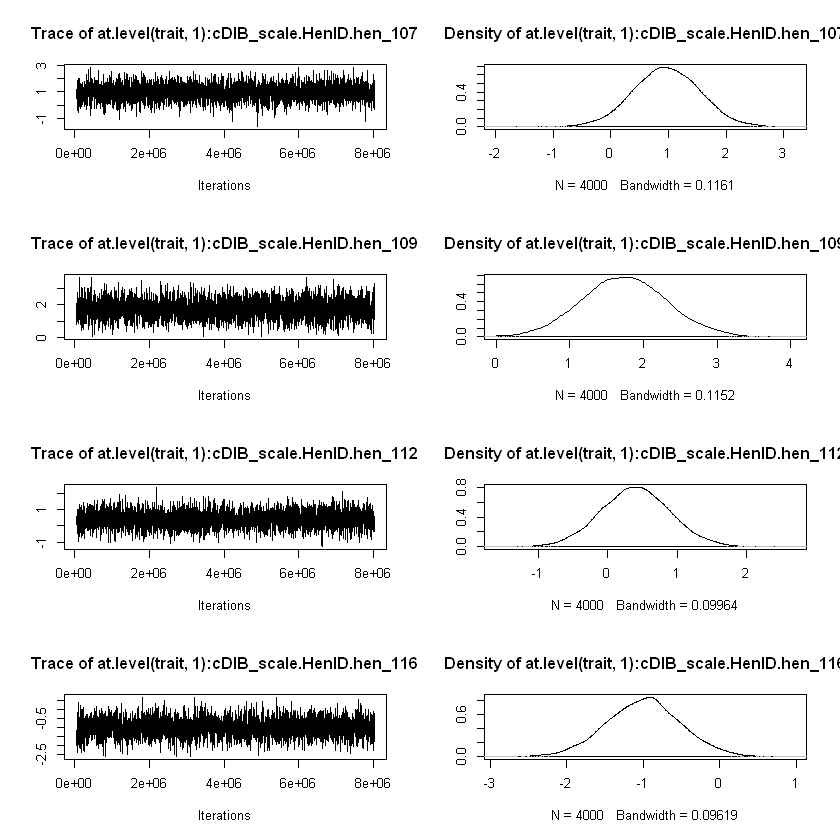

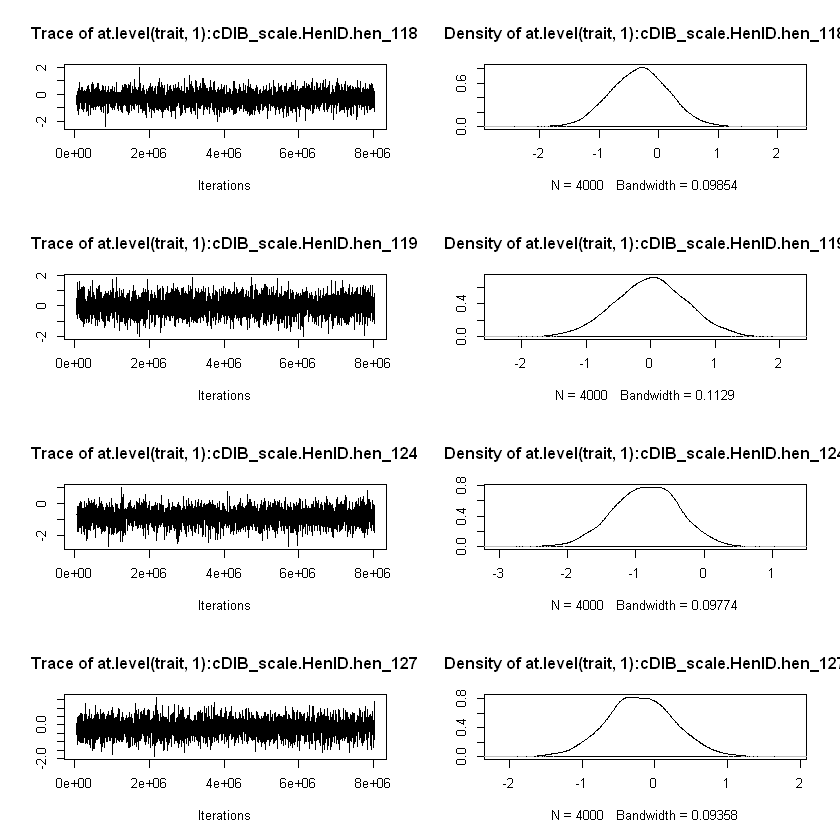

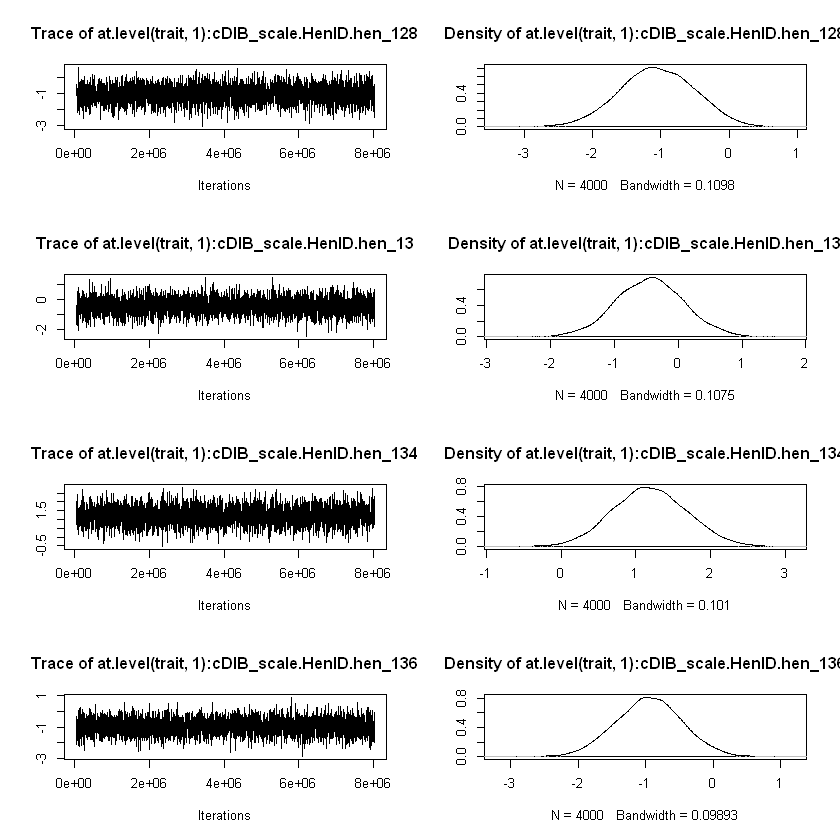

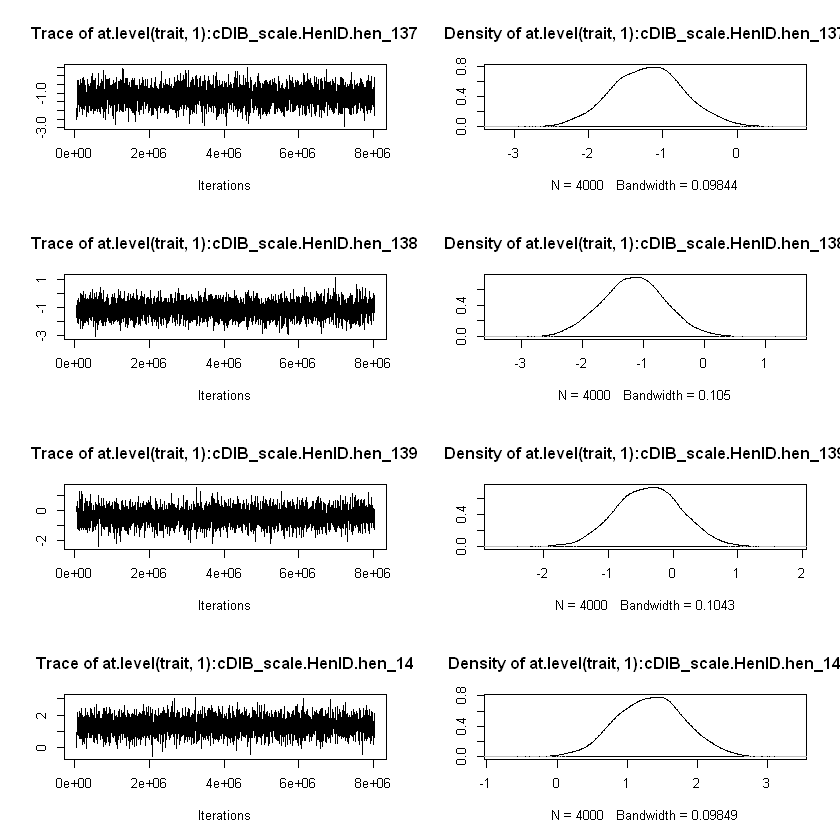

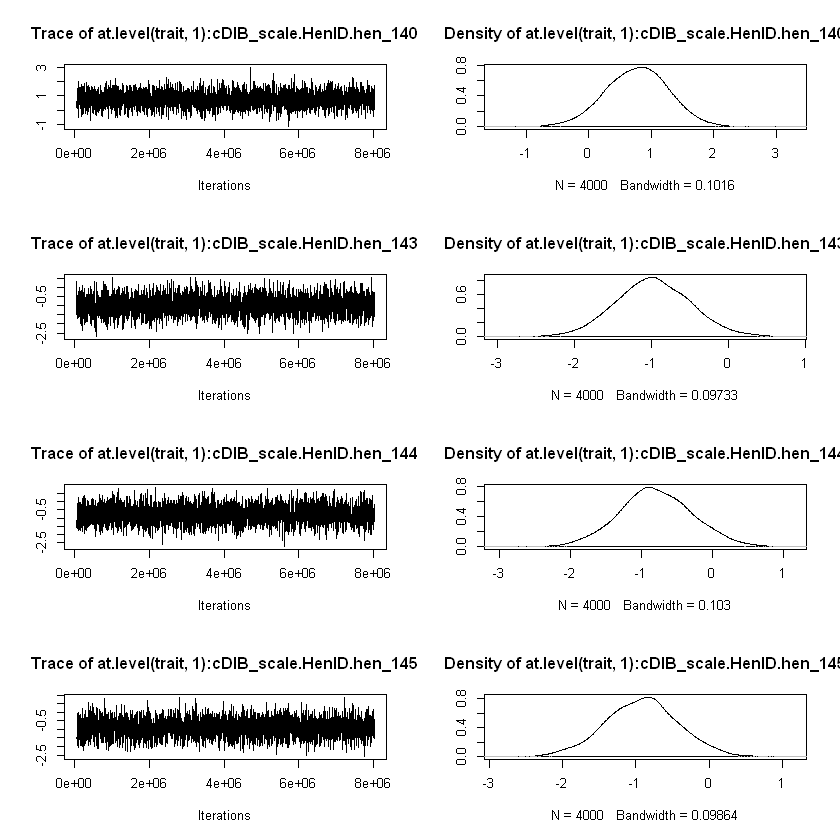

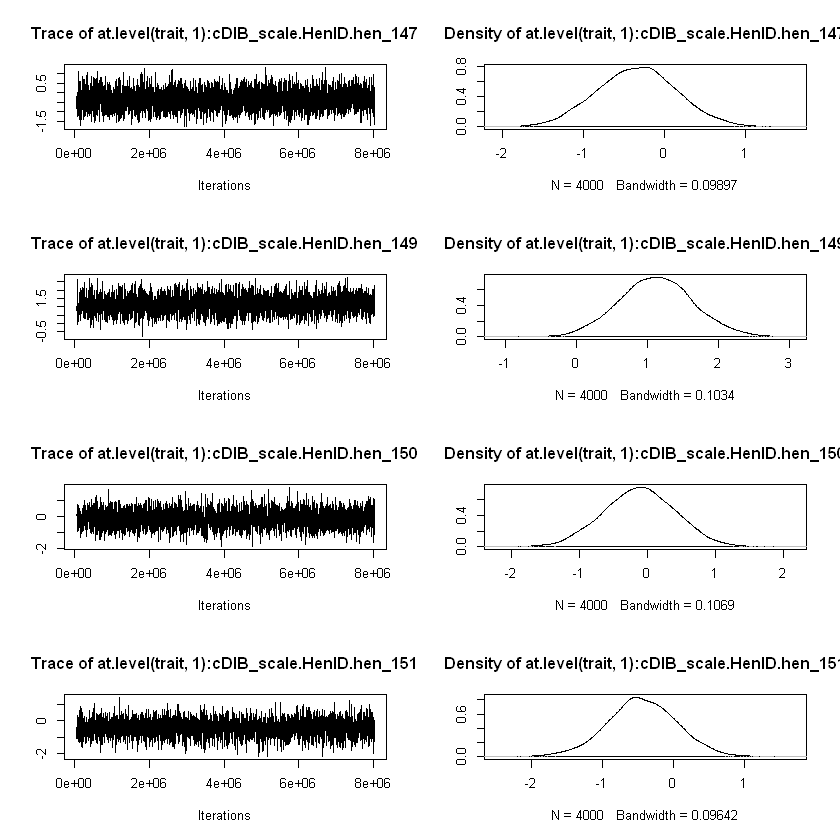

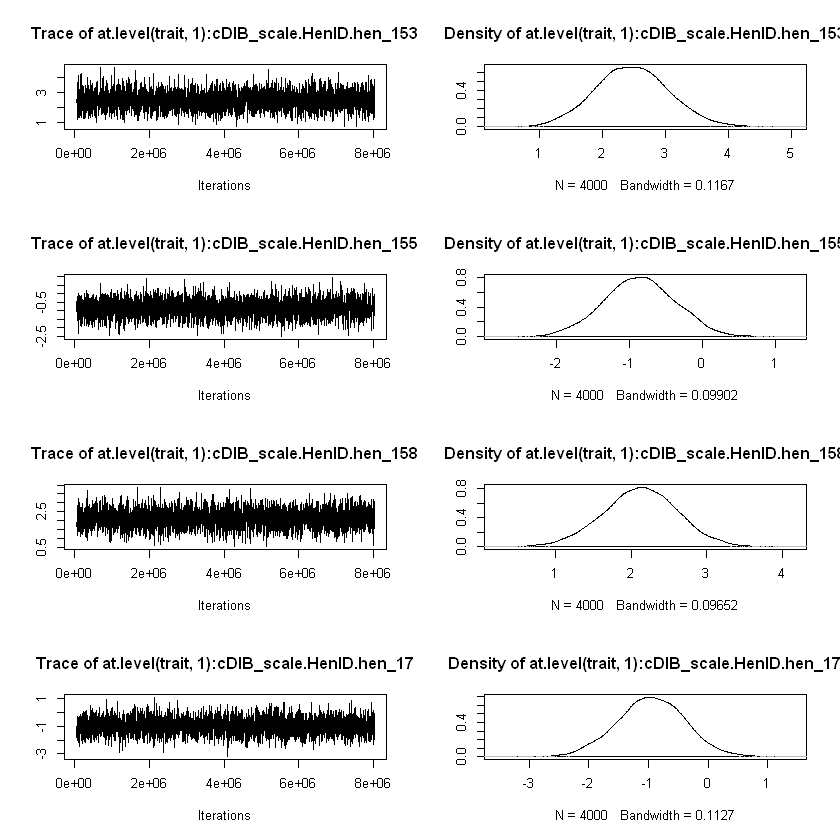

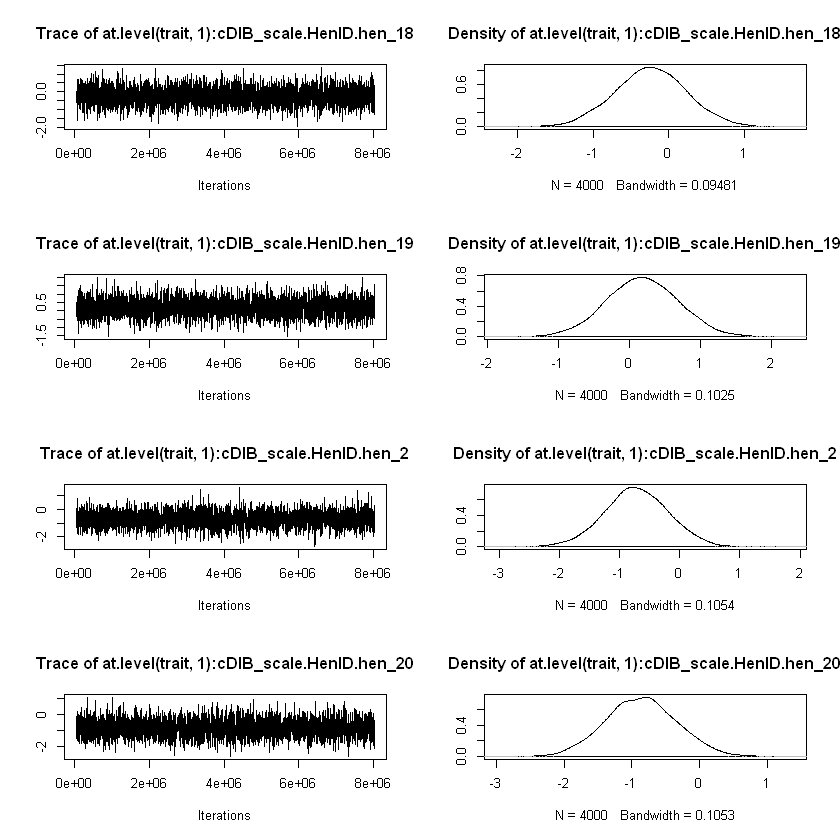

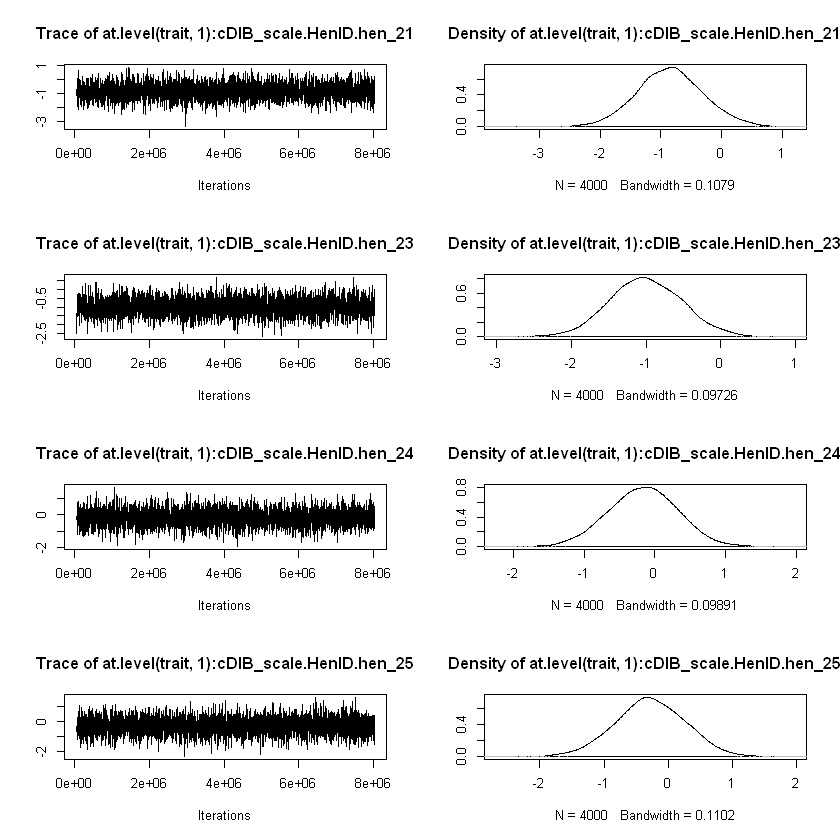

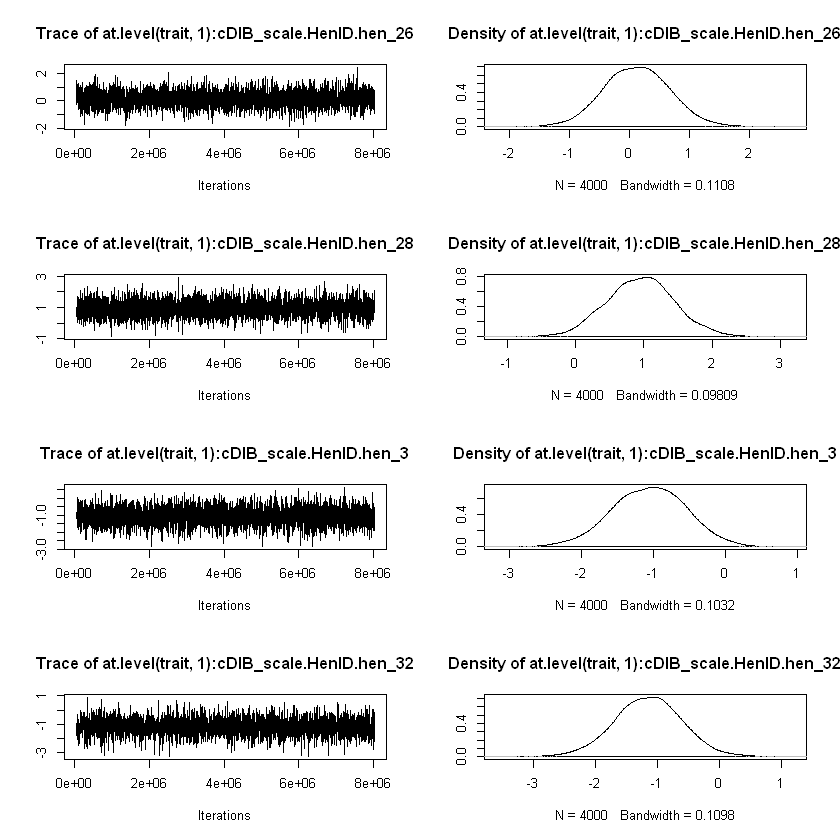

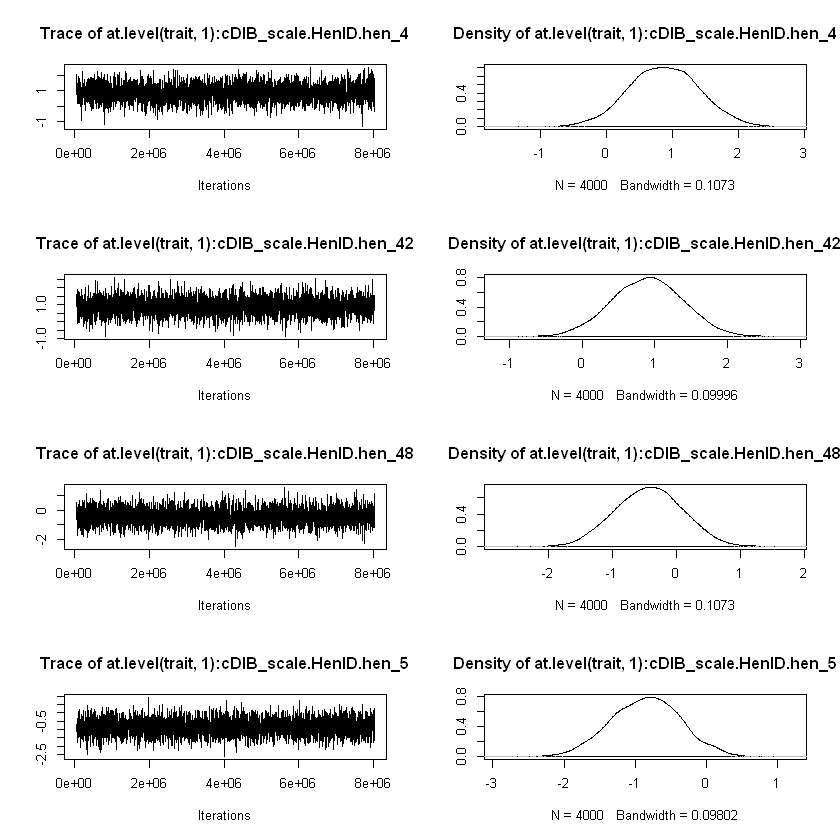

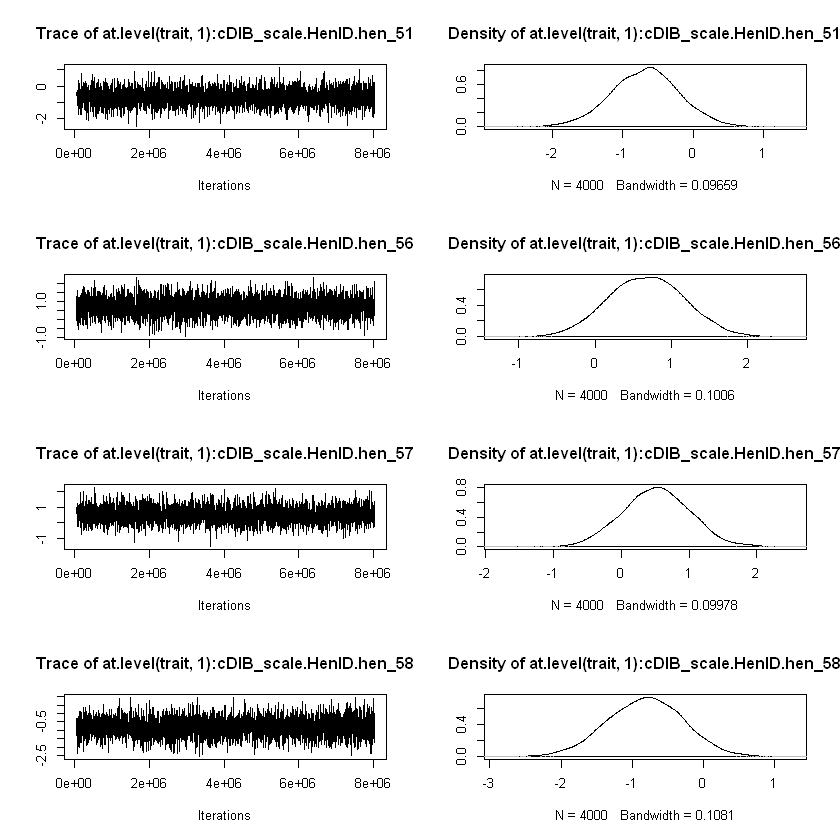

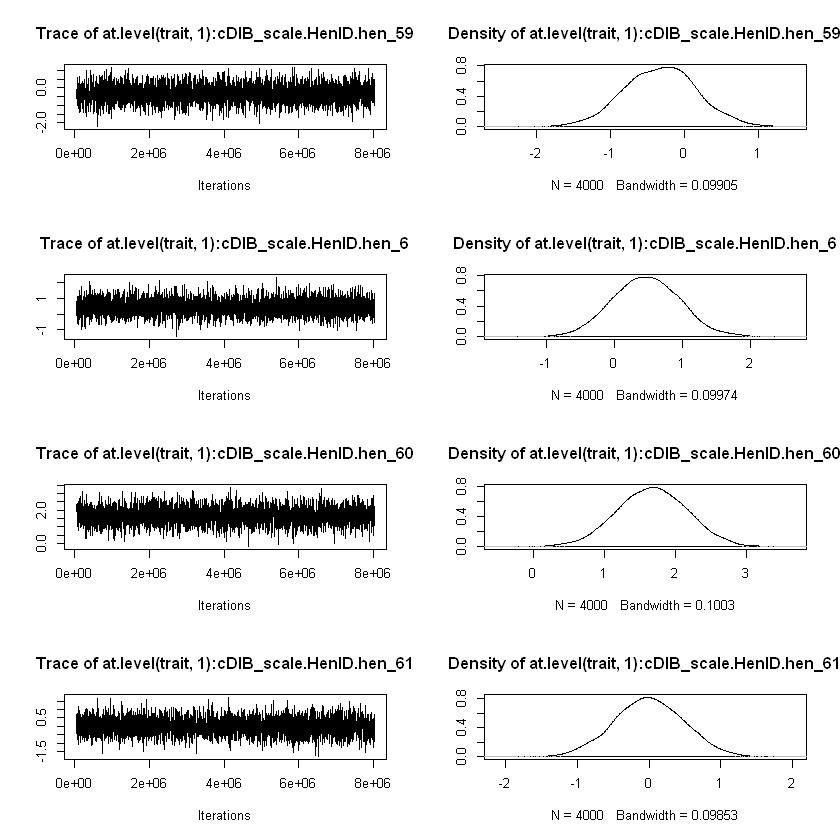

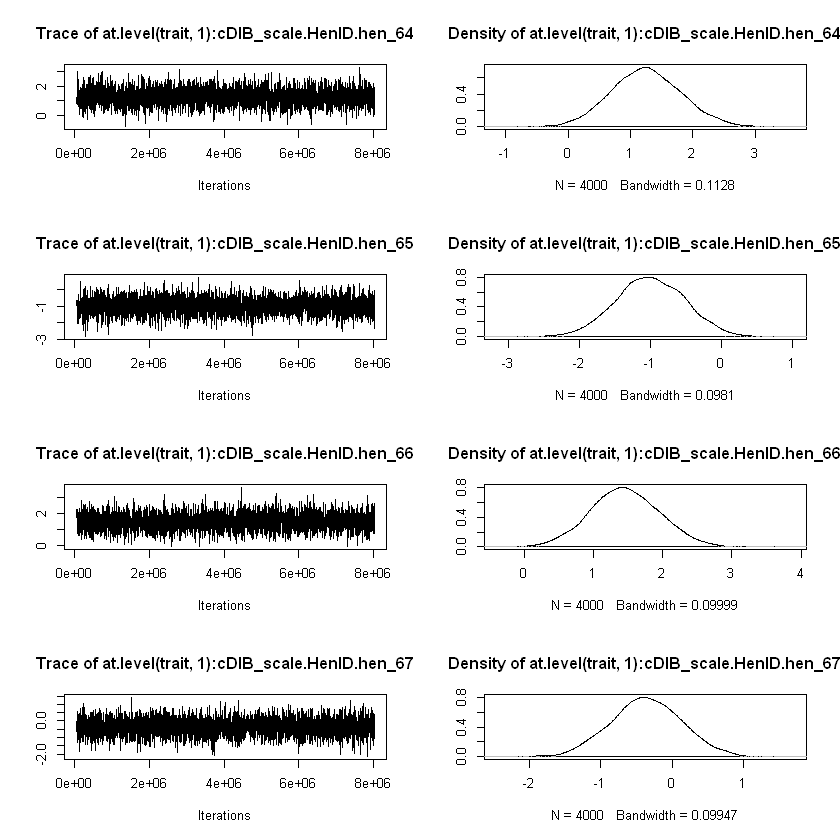

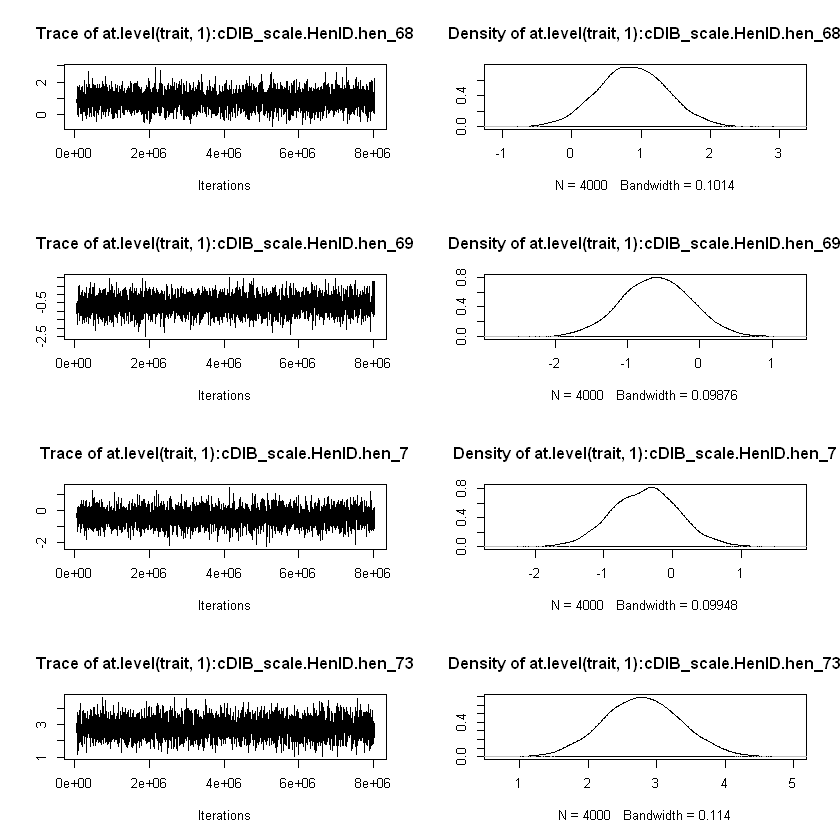

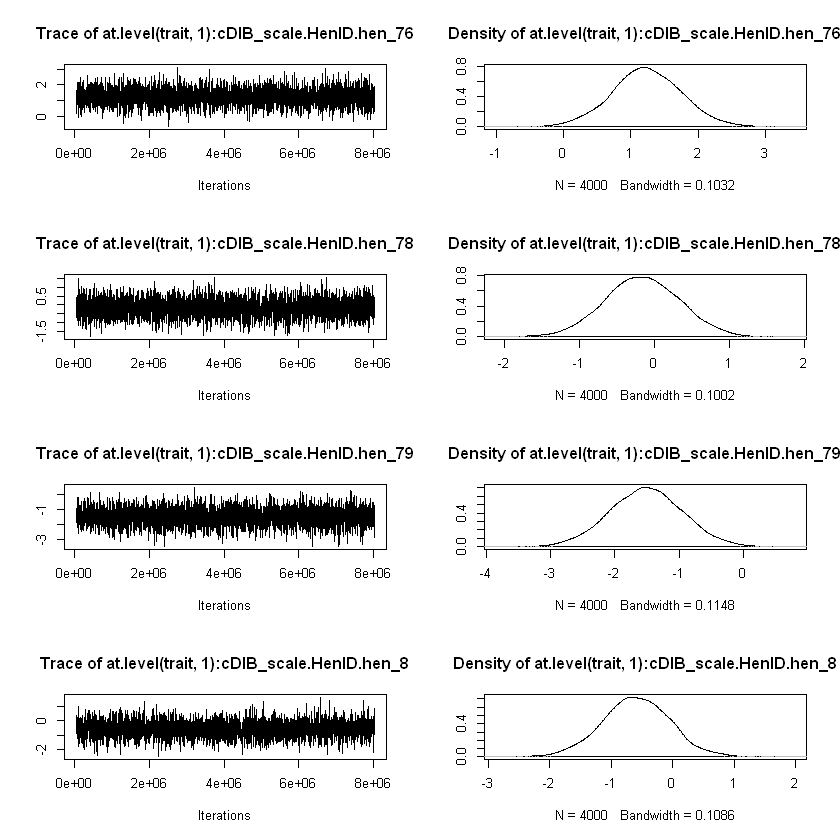

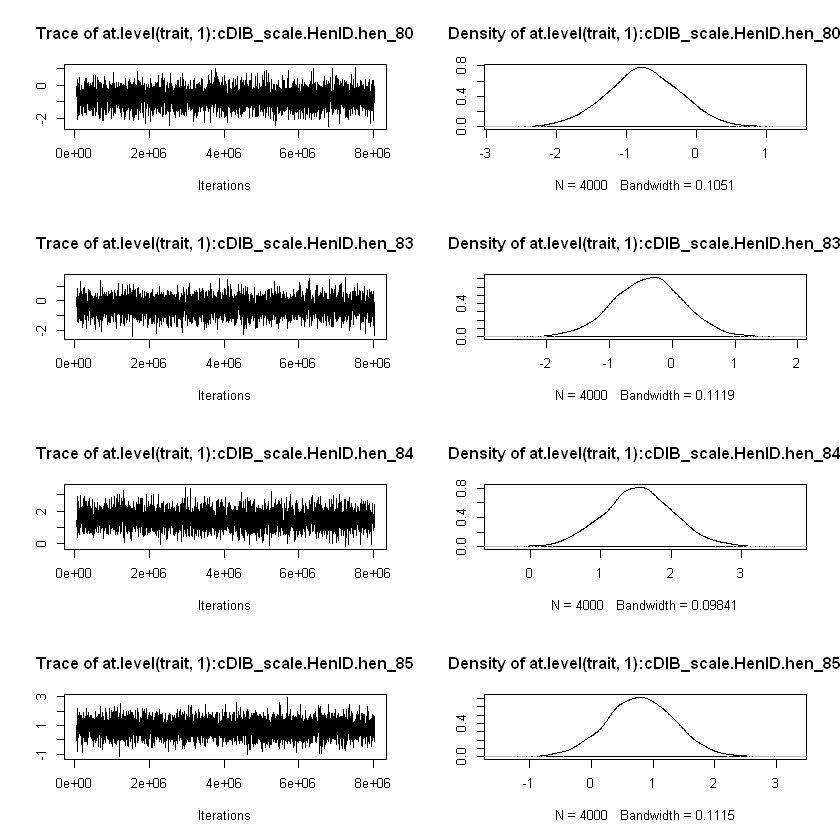

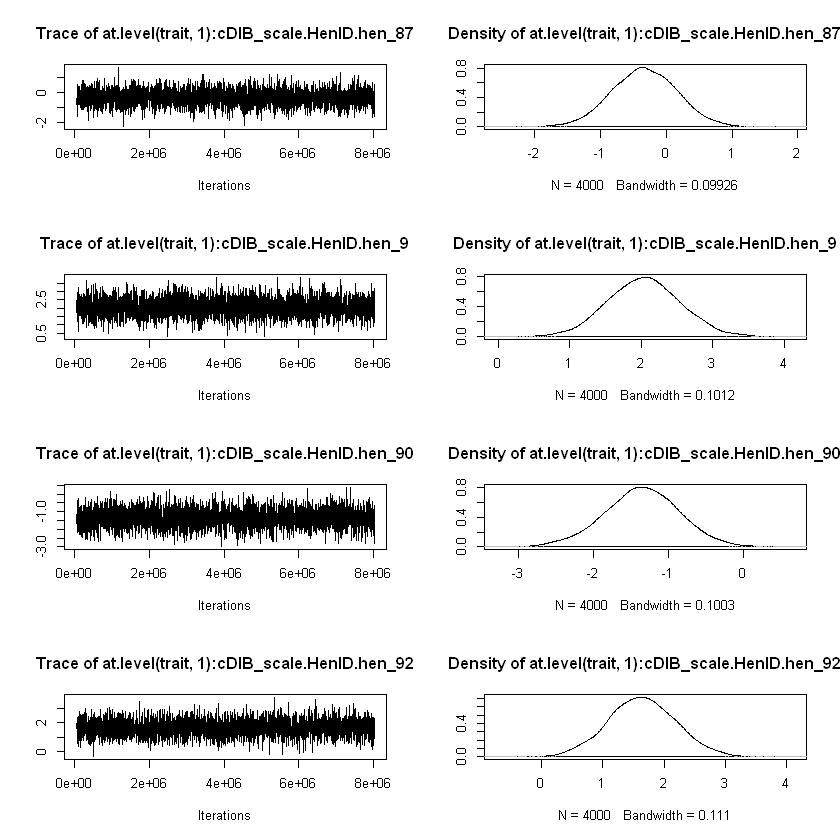

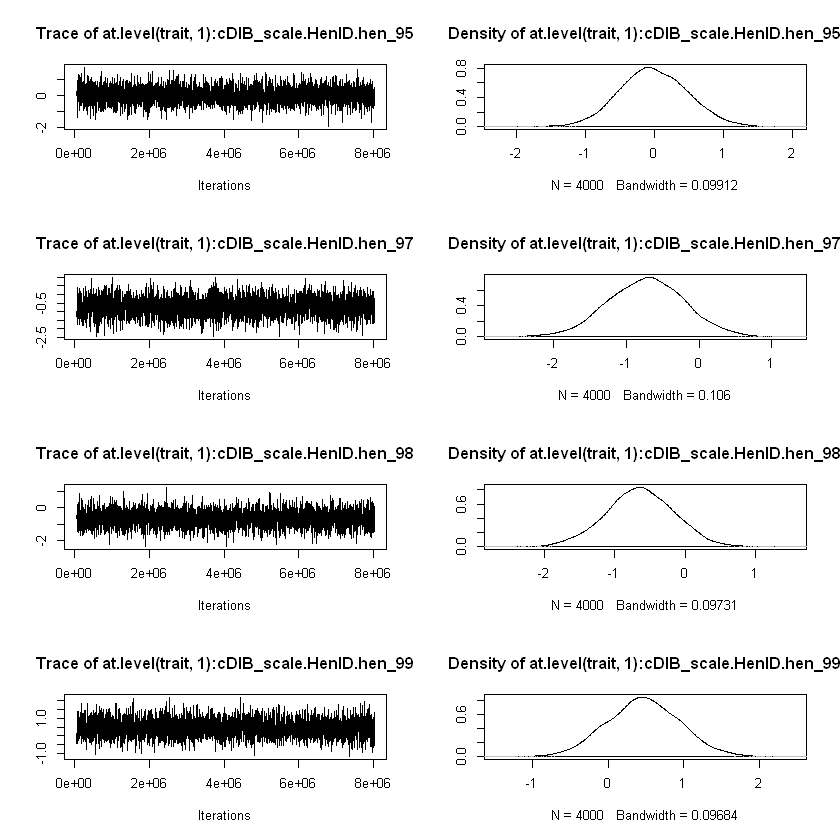

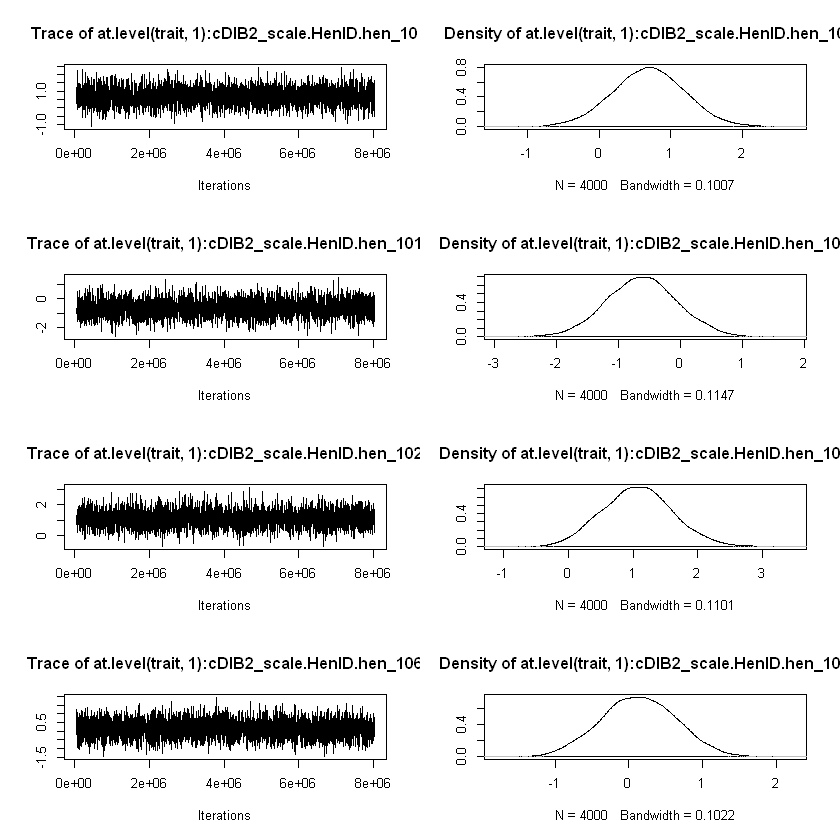

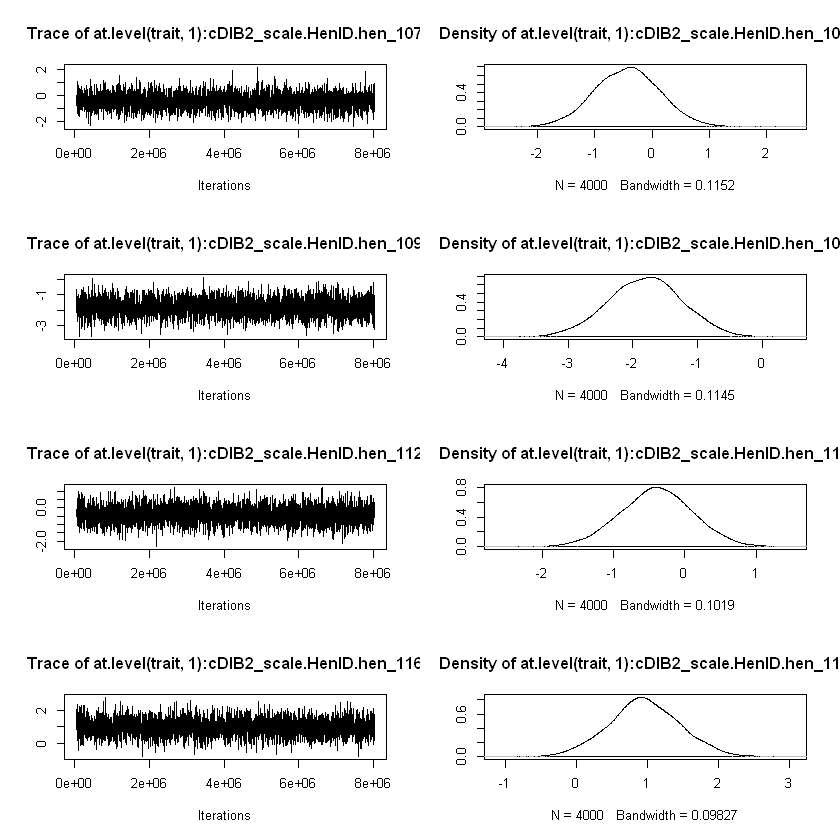

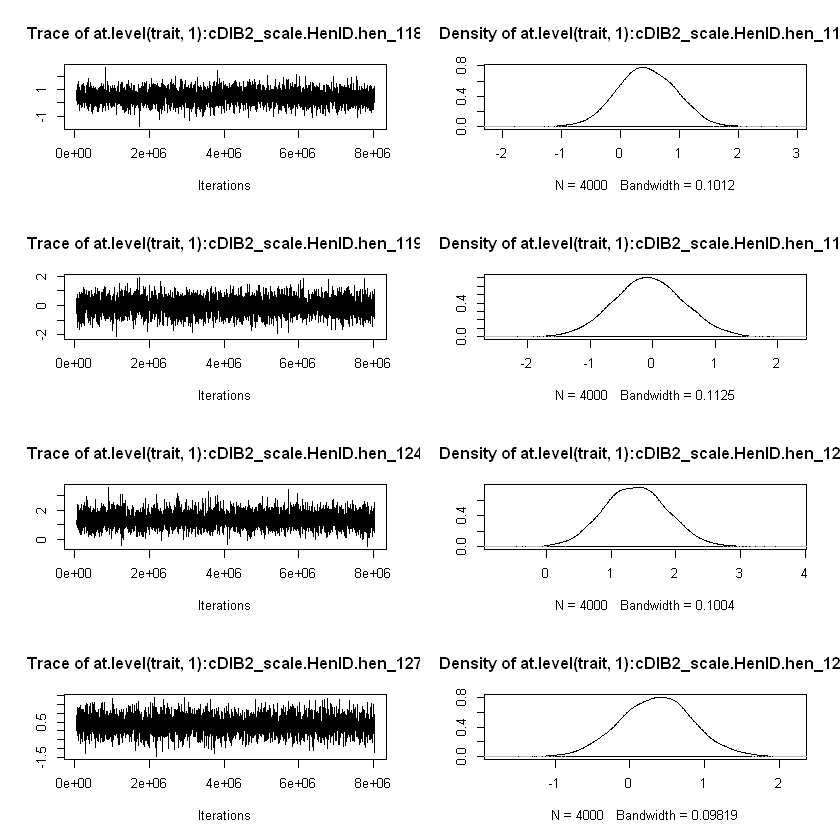

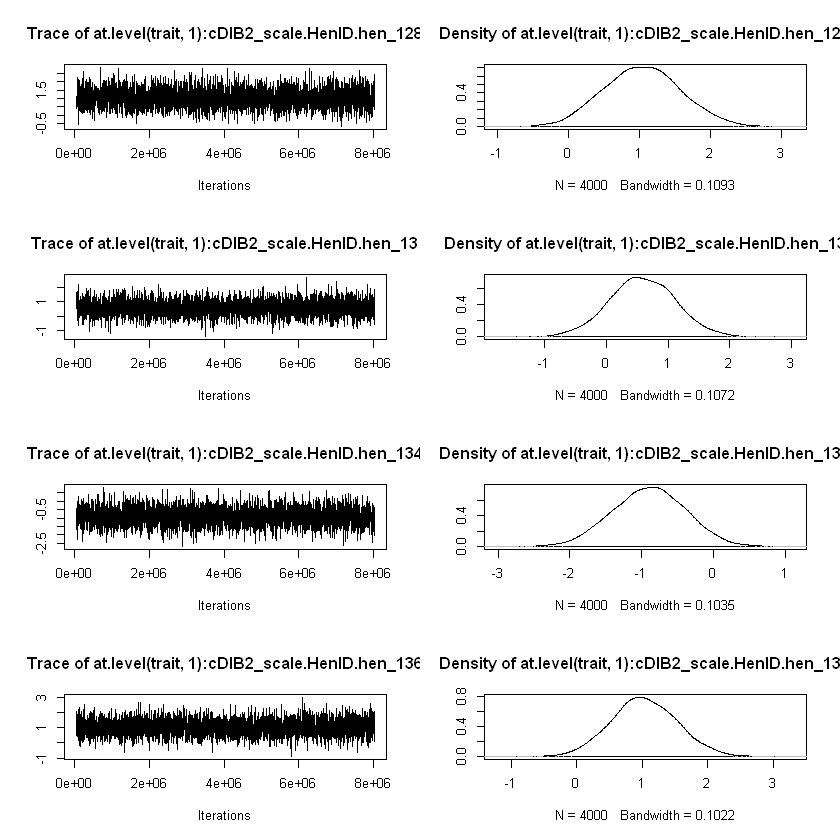

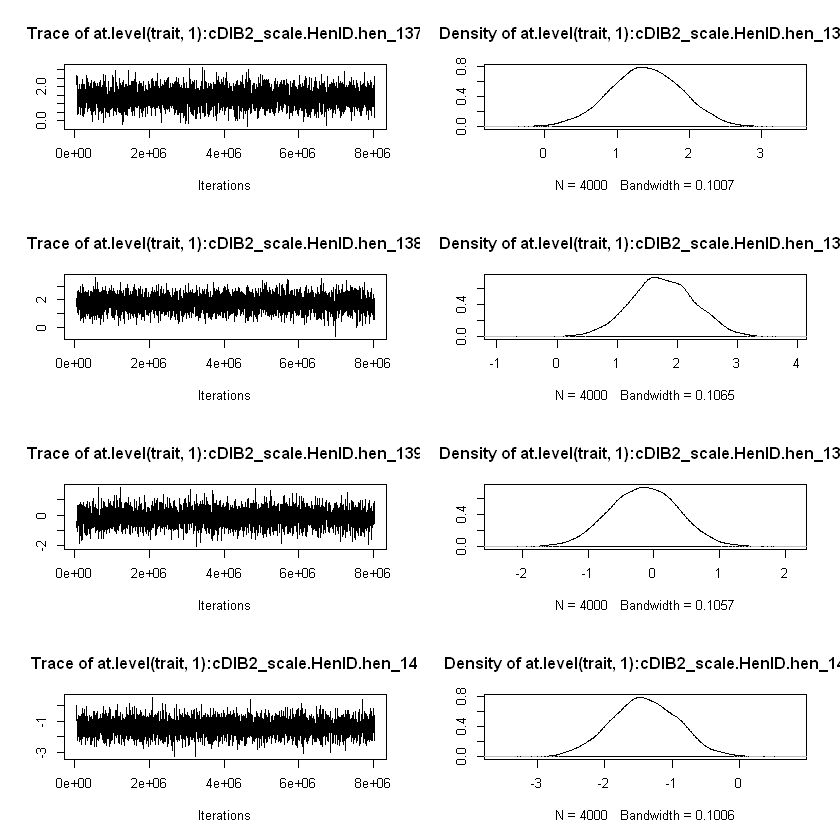

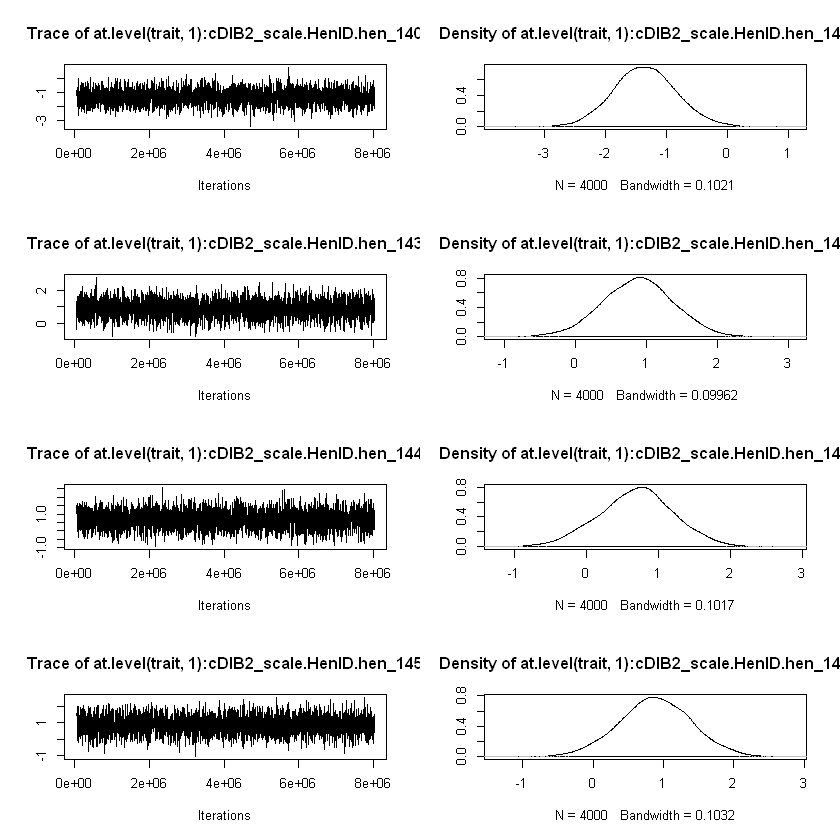

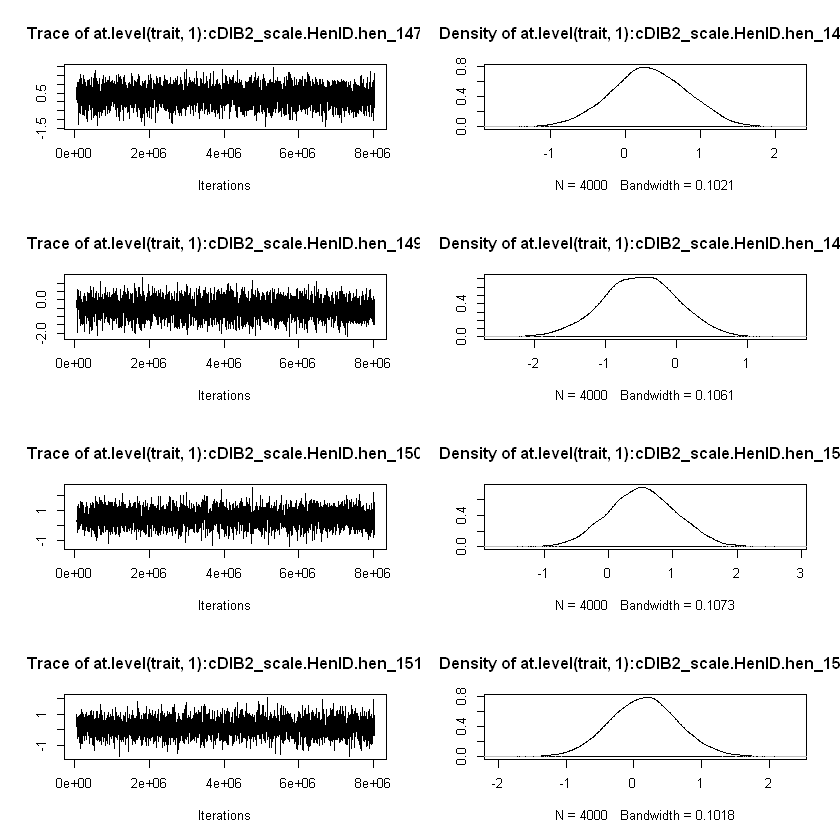

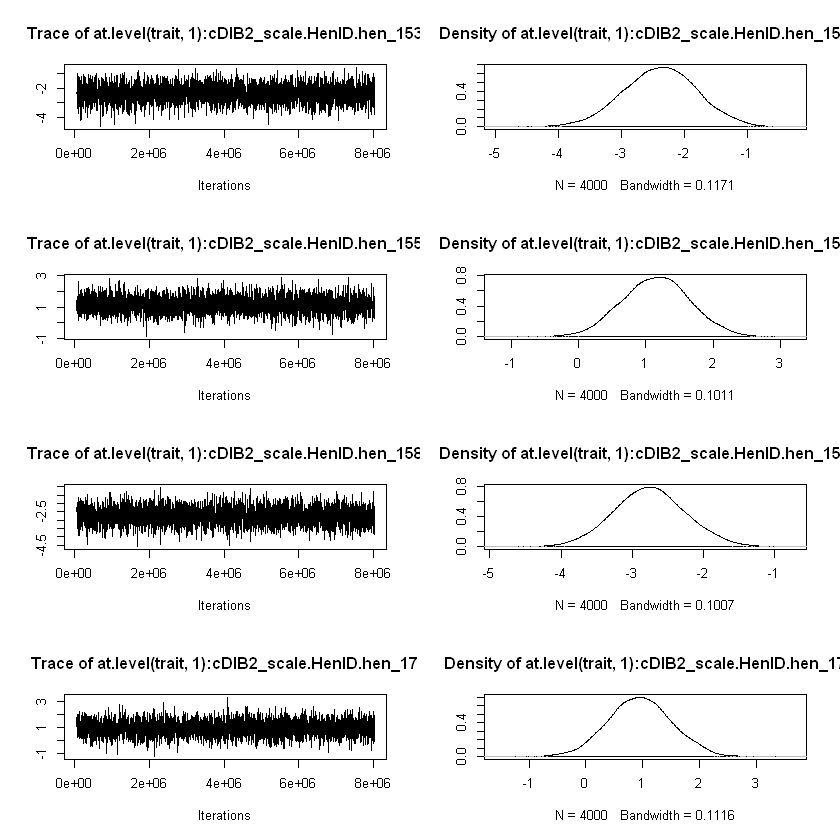

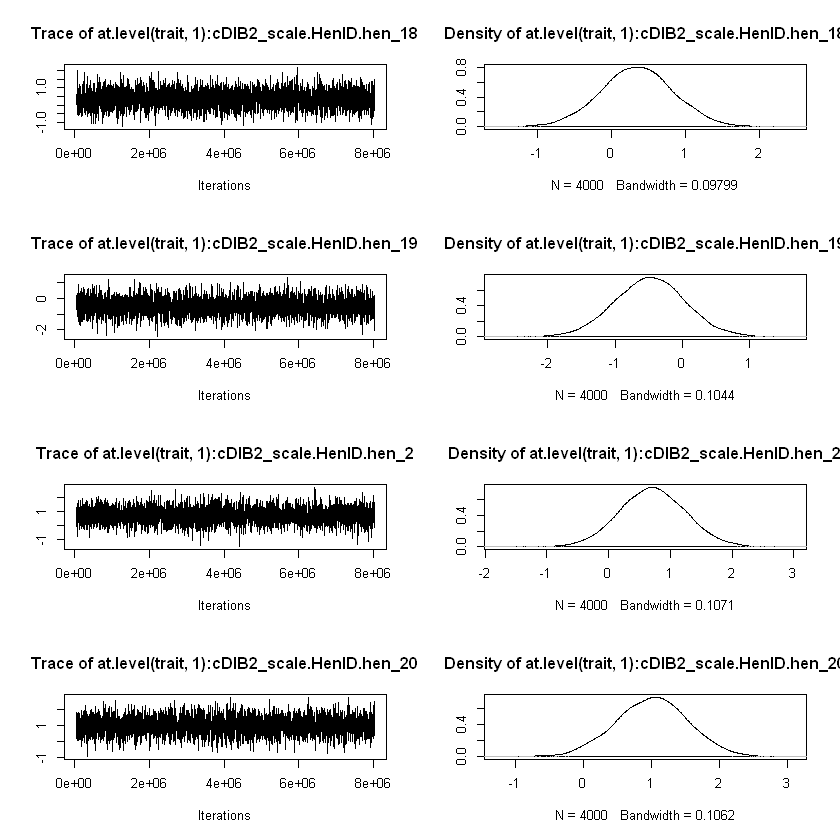

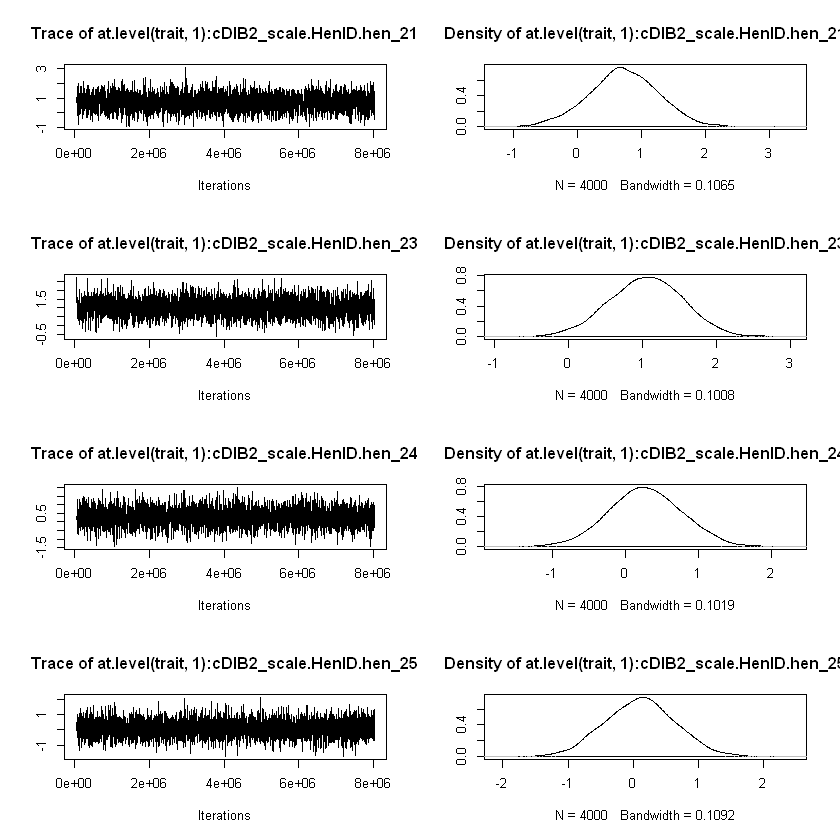

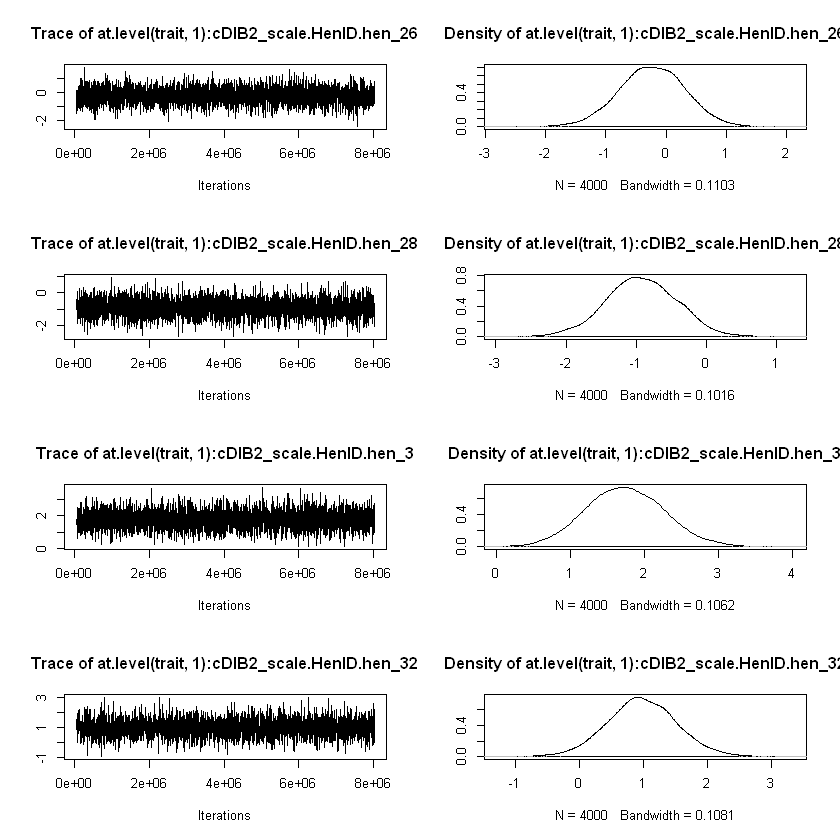

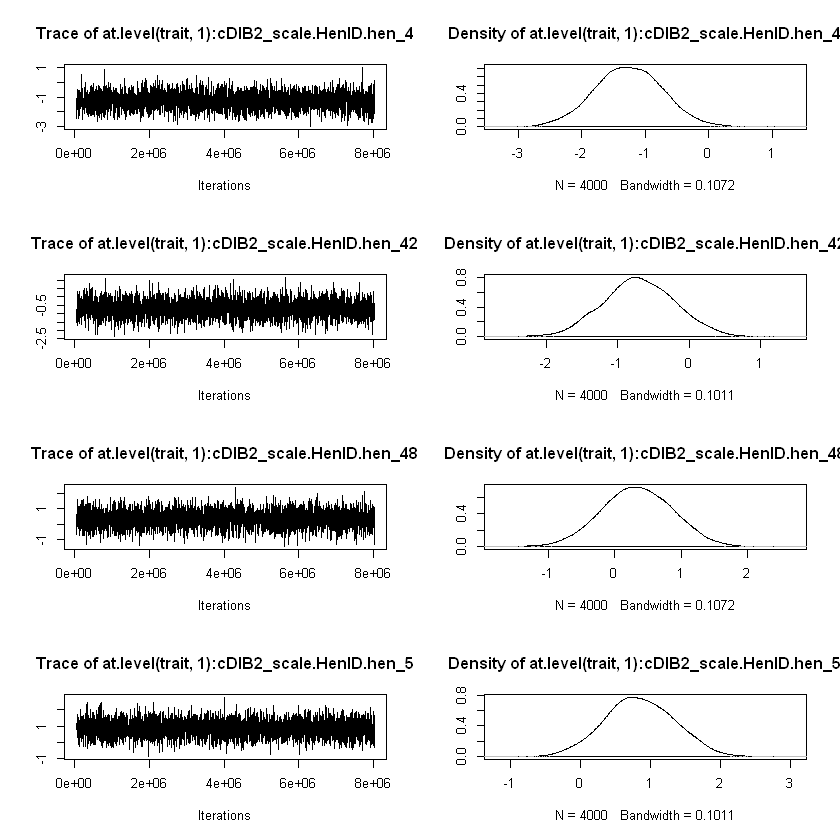

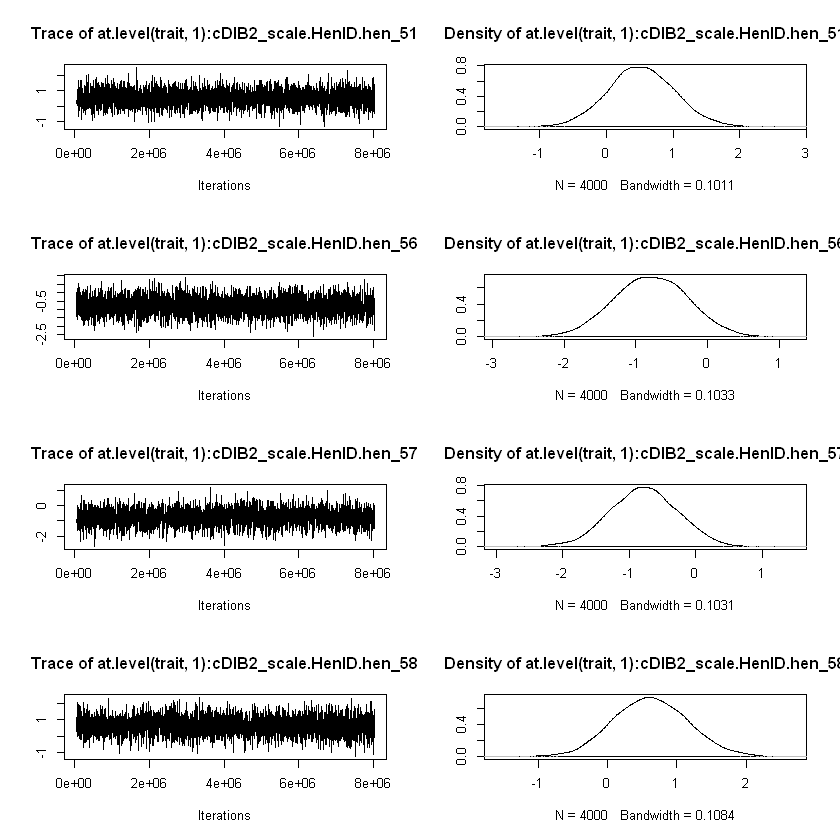

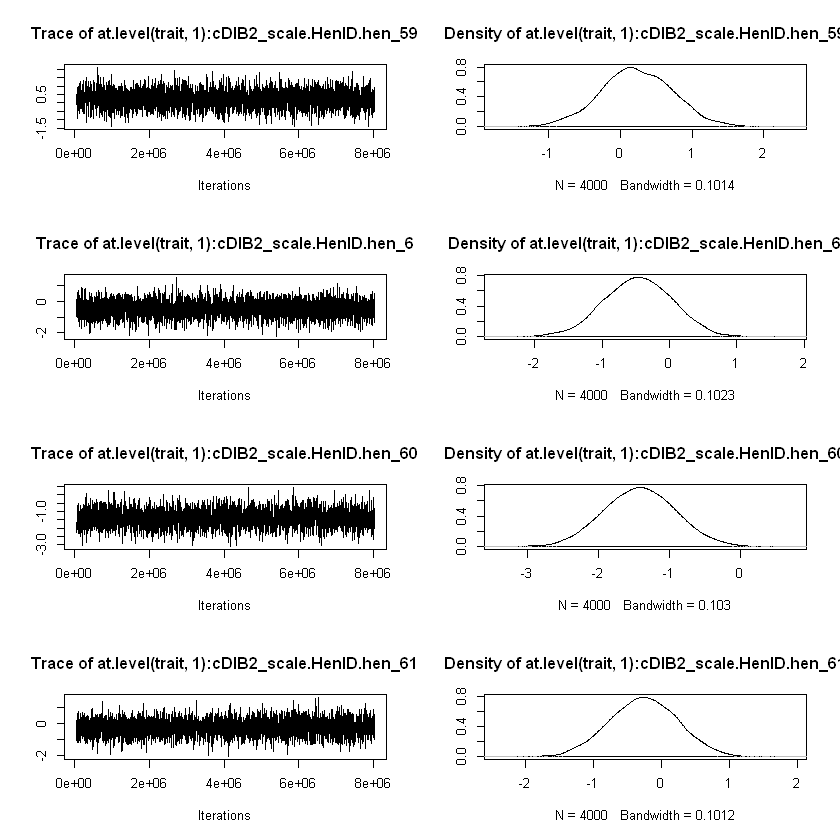

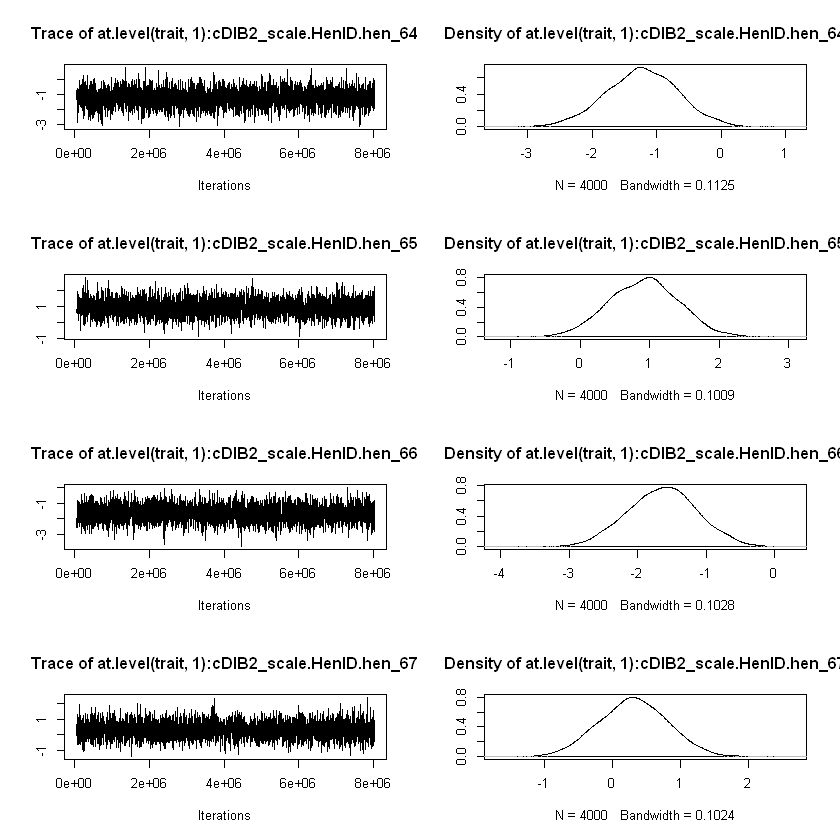

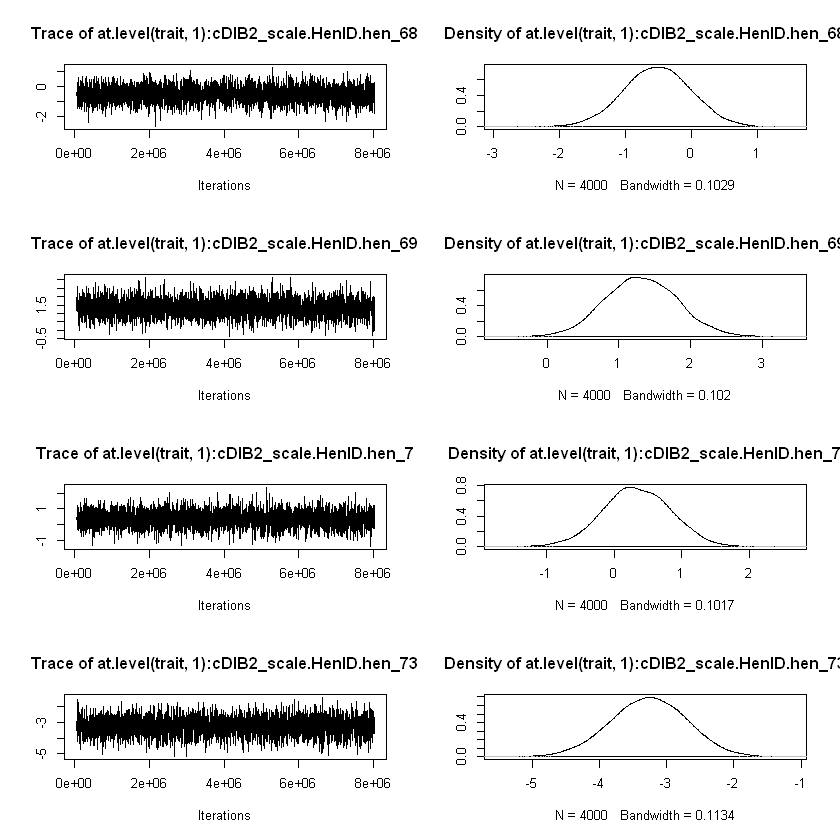

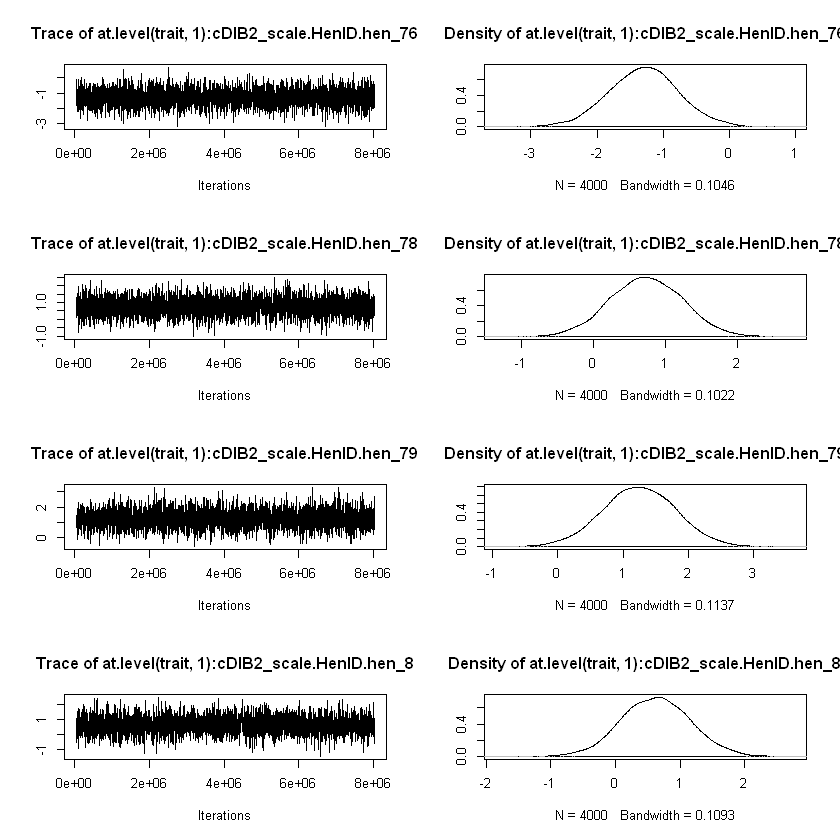

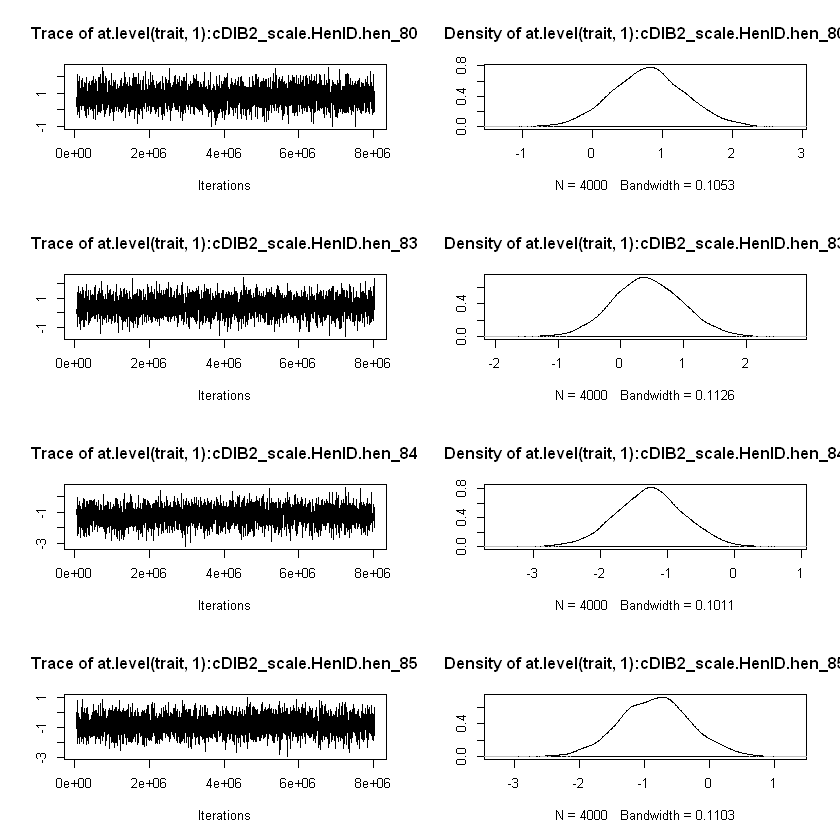

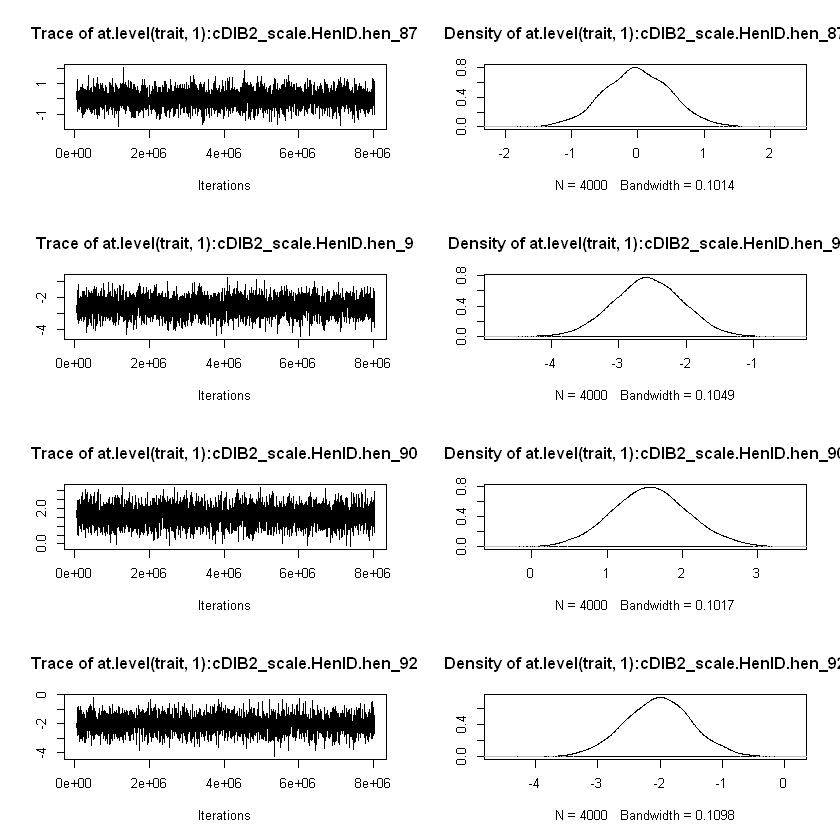


 Iterations = 50001:8048001
 Thinning interval  = 2000
 Sample size  = 4000 

 DIC: 100843.2 

 G-structure:  ~us(trait + at.level(trait, 1):cDIB_scale + at.level(trait, 1):cDIB2_scale):HenID

                                                                    post.mean
traitPC3:traitPC3.HenID                                               0.38927
traitrel_feather:traitPC3.HenID                                       0.03570
at.level(trait, 1):cDIB_scale:traitPC3.HenID                          0.47490
at.level(trait, 1):cDIB2_scale:traitPC3.HenID                        -0.48864
traitPC3:traitrel_feather.HenID                                       0.03570
traitrel_feather:traitrel_feather.HenID                               0.03080
at.level(trait, 1):cDIB_scale:traitrel_feather.HenID                  0.04113
at.level(trait, 1):cDIB2_scale:traitrel_feather.HenID                -0.05230
traitPC3:at.level(trait, 1):cDIB_scale.HenID                          0.47490
traitrel_feather:at.level(

var1 
0.3471072

,lower,upper
var1,0.1064654,0.5240418


var1 
0.1990465

,lower,upper
var1,-0.0514657,0.4465496


var1 
0.1990465

,lower,upper
var1,-0.0514657,0.4465496


,variable,post.mean,l.95..CI,u.95..CI,eff.samp,pMCMC,effect,modelName
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,traitPC3,-0.06987675,-0.2885700,0.1454687,4000.000,0.52700,fixed,BV_model_F1
2,traitrel_feather,1.08092704,0.9150128,1.2584548,4000.000,0.00025,fixed,BV_model_F1
3,"at.level(trait, 1):cDIB_scale",0.86585797,0.5814664,1.1519639,4377.257,0.00025,fixed,BV_model_F1


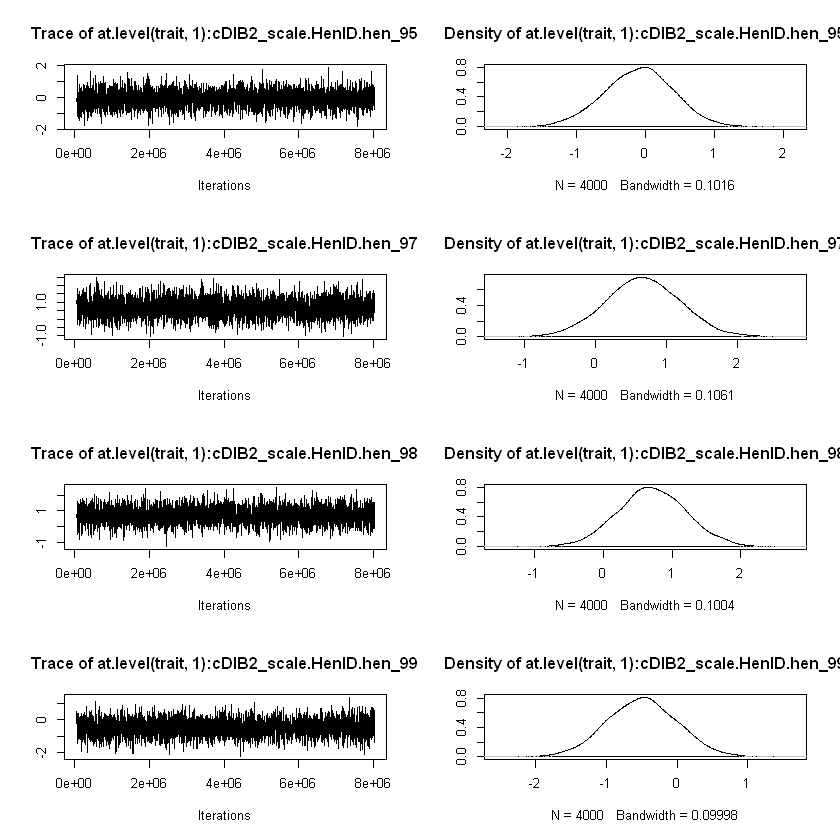

In [12]:
#without penID
#R: 2 response, 2 residuals
#QUESTION: nu=0.002 or 1.002
#G: only G1: only one random effect: of size 4: trait (2), cdib (1) and cdib2 (1)
prior_biv = list(R = list(V = diag(c(1, 0.0001), 2, 2), nu = 1.002, fix = 2),
                 G = list(G1 = list(V = diag(4),
                                        nu = 4,
                                        alpha.mu = rep(0,4),
                                        alpha.V = diag(25^2,4,4))))

#trait:scale: interact trait with fixed effects to get estimates for the effect of these variables on each of our mvt var
#"trait-1" tells the model to give us a distinct intercept for each trait"
#us: unstructured covariance matrix for the grouping variable henid: to calculate the variance in mvt var 1 due to differences among individuals, the varianc ein mvtvar2 due to differences among individulas and the covariance between these variances.
#rcov: idh: as we dont want COV_PC3:severity, as severity has not repeated measure on individuals
#random: unstructure covariance matrix of effects (intercepts & slope DIB), meaning that we fit variance in intercetps, in slopes but also their covariance: we want to know their correlations!
#random: without both trait with intercept, we wont be able to compute the correlation we want to! as we need the health intercept!
set.seed(123)
BV_model_F1 = MCMCglmm(cbind(PC3, rel_feather) ~ trait-1 +
                       at.level(trait,1):cDIB_scale +
                       at.level(trait,1):cDIB2_scale +
                       at.level(trait,1):avgDIB_scale +
                       at.level(trait,1):temperature_C_avg_scale +
                       at.level(trait,2):Predictability_mean +
                       at.level(trait,2):nbr_daysnomvt_over_3days +
                       trait:InitialWeight_kg_scale +
                       trait:Treatment_encoded + 
                       trait:CLASS,
                       random=~us(trait + at.level(trait,1):cDIB_scale + at.level(trait,1):cDIB2_scale):HenID, 
                       rcov=~idh(trait):units, 
                       family=c("gaussian","gaussian"),
                       prior=prior_biv,
                       data=df,
                       pr = TRUE, verbose = TRUE, saveX = TRUE, saveZ = TRUE,thin = thin, burnin= burn, nitt= nitt)
#G-structure: random effects (co)variances
#R-structure : the residual (co)variances, 
#Location : fixed effects results information
plot(BV_model_F1$VCV)
#trace plots for fixed effect
plot(BV_model_F1$Sol)
summary(BV_model_F1)

#################################### correlations HA & random effects
###correlation between intercept and health###
corr_int_health = BV_model_F1$VCV[,"traitrel_feather:traitPC3.HenID"]/
  (sqrt(BV_model_F1$VCV[,"traitrel_feather:traitrel_feather.HenID"])*
     sqrt(BV_model_F1$VCV[,"traitPC3:traitPC3.HenID"]))
posterior.mode(corr_int_health)
HPDinterval(corr_int_health)

###correlation between linear slope and health###
corr_Lslope_health = BV_model_F1$VCV[,"at.level(trait, 1):cDIB_scale:traitrel_feather.HenID"]/
  (sqrt(BV_model_F1$VCV[,"traitrel_feather:traitrel_feather.HenID"])*
     sqrt(BV_model_F1$VCV[,"at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB_scale.HenID"]))
posterior.mode(corr_Lslope_health)
HPDinterval(corr_Lslope_health)

###correlation between quadratic slope and health###
corr_Qslope_health = BV_model_F1$VCV[,"at.level(trait, 1):cDIB2_scale:traitrel_feather.HenID"]/
  (sqrt(BV_model_F1$VCV[,"traitrel_feather:traitrel_feather.HenID"])*
     sqrt(BV_model_F1$VCV[,"at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB2_scale.HenID"]))
posterior.mode(corr_Lslope_health)
HPDinterval(corr_Lslope_health)

#save
df_saved = clean.MCMC(BV_model_F1)  # get all the info from summary(modelName)
df_saved$modelName = getName.MCMC(BV_model_F1)  # add the model's name in a new column
head(df_saved,3)  # check out the created dataframe
write.csv(df_saved, file.path(path_adapt,'BV_model_F1.csv'))

In [13]:
autocorr.diag(BV_model_F1$Sol[,1:9]) #8 fixed effect and intercept
autocorr.diag(BV_model_F1$VCV)

,traitPC3,traitrel_feather,"at.level(trait, 1):cDIB_scale","at.level(trait, 1):cDIB2_scale","at.level(trait, 1):avgDIB_scale","at.level(trait, 1):temperature_C_avg_scale","at.level(trait, 2):Predictability_mean","at.level(trait, 2):nbr_daysnomvt_over_3days",traitPC3:InitialWeight_kg_scale
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000
Lag 2000,-0.017245830,0.020054014,-0.007851464,-0.004473116,-0.001494958,0.020412012,0.022452491,0.000609069,0.005789765
Lag 10000,0.018728769,0.014726764,0.013508201,0.023156036,0.008386785,-0.008548072,0.016249379,-0.022319330,0.022965259
Lag 20000,-0.001706564,-0.007620813,0.008356473,0.006707255,0.006447450,-0.005013167,-0.007610706,0.013521653,0.002063294
Lag 1e+05,-0.016248182,0.004207994,-0.035225946,-0.027512181,0.019500648,-0.027971844,-0.004541086,-0.029554918,0.006751450


,traitPC3:traitPC3.HenID,traitrel_feather:traitPC3.HenID,"at.level(trait, 1):cDIB_scale:traitPC3.HenID","at.level(trait, 1):cDIB2_scale:traitPC3.HenID",traitPC3:traitrel_feather.HenID,traitrel_feather:traitrel_feather.HenID,"at.level(trait, 1):cDIB_scale:traitrel_feather.HenID","at.level(trait, 1):cDIB2_scale:traitrel_feather.HenID","traitPC3:at.level(trait, 1):cDIB_scale.HenID","traitrel_feather:at.level(trait, 1):cDIB_scale.HenID","at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB_scale.HenID","at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB_scale.HenID","traitPC3:at.level(trait, 1):cDIB2_scale.HenID","traitrel_feather:at.level(trait, 1):cDIB2_scale.HenID","at.level(trait, 1):cDIB_scale:at.level(trait, 1):cDIB2_scale.HenID","at.level(trait, 1):cDIB2_scale:at.level(trait, 1):cDIB2_scale.HenID",traitPC3.units,traitrel_feather.units
Lag 0,1.00000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.0000000000,NaN
Lag 2000,0.01315180,0.014962109,0.005175030,0.013772941,0.014962109,0.046376168,0.0003843826,0.015302545,0.005175030,0.0003843826,0.018483417,0.026763819,0.013772941,0.015302545,0.026763819,0.0313555498,0.0002777871,NaN
Lag 10000,-0.02171048,-0.016143344,-0.001484873,0.008209358,-0.016143344,0.034758012,-0.0202444569,-0.015415138,-0.001484873,-0.0202444569,0.017144908,0.022908360,0.008209358,-0.015415138,0.022908360,0.0297778905,0.0217861374,NaN
Lag 20000,-0.00410702,0.005467799,0.006717504,0.006600632,0.005467799,0.036473098,0.0025276051,0.008513099,0.006717504,0.0025276051,0.001612843,0.001689899,0.006600632,0.008513099,0.001689899,-0.0005027615,-0.0171795813,NaN
Lag 1e+05,0.03026497,0.014114430,0.021229585,0.021955265,0.014114430,-0.000399956,0.0249300396,0.028568453,0.021229585,0.0249300396,-0.009242110,-0.014022867,0.021955265,0.028568453,-0.014022867,-0.0180411717,0.0065221489,NaN


In [14]:
path_adapt = 'C:/Users/camil/Desktop/animals_code/PhD-AnimalWelfare/Chapter1-EarlyMovementLateHealth/FICHIER'
save(BV_model_F1, file = file.path(path_adapt,"BV_model_F1.RData"))
#load(coda.samples.RData)